# Problem Statement

## Context

### Problem Statement

Kampanye penawaran pembukaan term deposit (deposito) akan membutuhkan banyak waktu dan sumber day jika perusahaan menargetkan semua nasabah tanpa melakukan penyaringan. Pihak bank ingin meningkatkan efesiensi penawaran dengan mengetahui nasabah mana yang kemungkinan besar ingin membuka term deposit (deposito).

### Goals

Melihat dari permasalahan yang dimiliki, maka bank ingin memiliki kemampuan untuk memprediksi kemungkinan seorang nasabah untuk membuka term deposit atau tidak, sehingga dapat memfokuskan penawaran pada nasabah yang bersedia.

Dan juga, bank ingin mengetahui apa/factor/variable yang membuat seorang nasabah ingin membuka term deposit (deposito) atau tidak, sehingga divisi marketing dapat membuat rencana lebih baik dalam mendekati nasabah potensial.

### Analytic Approach 

Jadi yang akan dilakukan adalah menganalisis data untuk menemukan pola yang membedakan nasabah yang mau membuka term deposit atau tidak.

Kemudian akan dibangun model klasifikasi yang akan membantu perusahaan untuk dapat memprediksi probabilitas seorang kandidat akan/ingin membuka term deposit (deposito) atau tidak.

### Metriks Evaluasi

![Alt text](image\me.jpg)

Type 1 error : False Positive

Konsekuensi : Sia-sianya biaya penawaran, waktu dan sumber daya

Type 2 error : False Negative

Konsekuensi : Kehilangan Nasabah Potensial.

In [1]:
# Library

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
import plotly.express as px
from IPython.display import display
from plotnine import *
import plotnine

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from category_encoders import BinaryEncoder
import category_encoders as ce
from sklearn.preprocessing import FunctionTransformer
import scipy.stats as stats
from sklearn.feature_selection import RFE, RFECV

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score, matthews_corrcoef,precision_recall_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics


# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)


# DATA UNDERSTANDING

Data Source : https://archive.ics.uci.edu/ml/datasets/bank+marketing

Bank Marketing Campaign

Sebuah dataset yang mendeskripsikan hasil kampanye market sebuah bank di Portugal. Kampanye dilakukan kebanyakan lewat telepon, menawarkan klien untuk melakukan deposito. Jika setuju makan target variabel akan diisi oleh ‘yes’ selain itu ‘no’


Deposito : jenis rekening deposito dimana dana yang ada akan dikunci dalam jjangka waktu tertentu.

Feature description

Bank client data:

1 - age (numeric)

2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical: basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')

Related with the last contact of the current campaign:

8 - contact: contact communication type (categorical: 'cellular','telephone')

9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

other attributes:

12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

social and economic context attributes

16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)

17 - cons.price.idx: consumer price index - monthly indicator (numeric)

18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)

19 - euribor3m: euribor 3 month rate - daily indicator (numeric)

20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):

21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

* Data set tidak seimbang
* terdapat 41188 data dengan 20 fitur
* 10 fitur kategorikal dan 10 fitur numerical

In [2]:
#Load Dataset
df = pd.read_csv('data-bank.csv',sep = ';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [4]:
display(df.describe(), df.describe(include='object'))

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


In [5]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,age,int64,0,0.0,78,"[29, 79]"
1,job,object,0,0.0,12,"[admin., unknown]"
2,marital,object,0,0.0,4,"[unknown, single]"
3,education,object,0,0.0,8,"[basic.4y, illiterate]"
4,default,object,0,0.0,3,"[no, yes]"
5,housing,object,0,0.0,3,"[unknown, yes]"
6,loan,object,0,0.0,3,"[unknown, no]"
7,contact,object,0,0.0,2,"[telephone, cellular]"
8,month,object,0,0.0,10,"[jun, apr]"
9,day_of_week,object,0,0.0,5,"[fri, mon]"


# Explaratory Data Analysis

## Distribusi

In [6]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [7]:
df.describe(include=['O'])

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


## Korelasi

In [8]:
import phik
from phik.report import plot_correlation_matrix
from phik import report

In [9]:
phik_overview = df.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
age,1.00,0.52,0.42,0.24,0.24,0.00,0.02,0.13,0.29,0.06,0.00,0.00,0.18,0.13,0.18,0.27,0.26,0.36,0.29,0.30,0.22
job,0.52,1.00,0.38,0.67,0.32,0.02,0.02,0.16,0.26,0.03,0.02,0.00,0.18,0.13,0.22,0.33,0.30,0.25,0.29,0.34,0.20
marital,0.42,0.38,1.00,0.25,0.10,0.01,0.00,0.11,0.08,0.01,0.00,0.00,0.06,0.07,0.04,0.10,0.11,0.12,0.15,0.11,0.08
education,0.24,0.67,0.25,1.00,0.26,0.02,0.00,0.16,0.20,0.03,0.00,0.00,0.07,0.06,0.07,0.12,0.20,0.13,0.18,0.13,0.09
default,0.24,0.32,0.10,0.26,1.00,0.04,0.01,0.08,0.19,0.02,0.00,0.04,0.05,0.12,0.24,0.35,0.33,0.23,0.24,0.31,0.06
housing,0.00,0.02,0.01,0.02,0.04,1.00,0.94,0.05,0.09,0.02,0.00,0.05,0.00,0.03,0.06,0.12,0.16,0.07,0.08,0.10,0.01
loan,0.02,0.02,0.00,0.00,0.01,0.94,1.00,0.01,0.03,0.01,0.00,0.05,0.00,0.00,0.00,0.03,0.04,0.02,0.02,0.02,0.00
contact,0.13,0.16,0.11,0.16,0.08,0.05,0.01,1.00,0.77,0.04,0.04,0.07,0.18,0.32,0.15,0.63,0.67,0.54,0.62,0.68,0.23
month,0.29,0.26,0.08,0.20,0.19,0.09,0.03,0.77,1.00,0.16,0.07,0.10,0.31,0.26,0.37,0.85,0.89,0.94,0.80,0.83,0.36
day_of_week,0.06,0.03,0.01,0.03,0.02,0.02,0.01,0.04,0.16,1.00,0.02,0.03,0.01,0.00,0.02,0.05,0.09,0.11,0.22,0.07,0.02


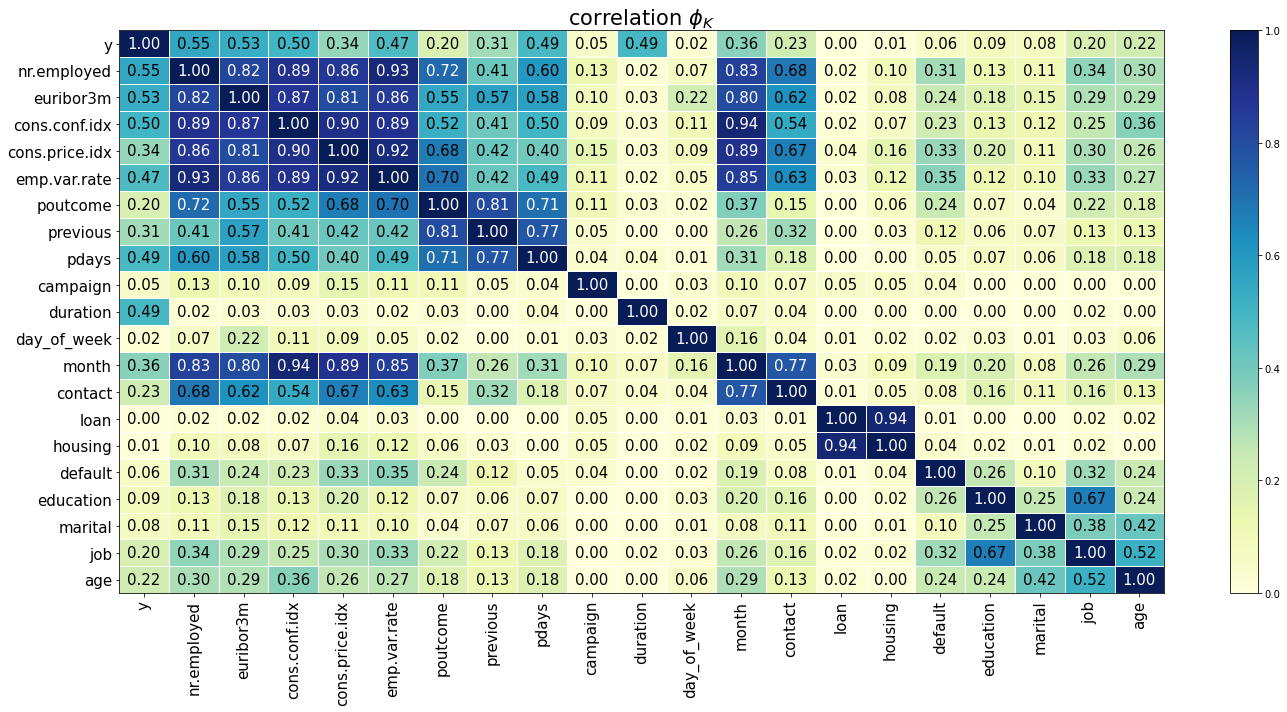

In [10]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="YlGnBu", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(20, 10))
plt.tight_layout()

## Kardinalitas Data

In [11]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)])

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,age,int64,0,0.0,78,"[68, 82]"
1,job,object,0,0.0,12,"[self-employed, management]"
2,marital,object,0,0.0,4,"[married, single]"
3,education,object,0,0.0,8,"[basic.4y, basic.6y]"
4,default,object,0,0.0,3,"[yes, no]"
5,housing,object,0,0.0,3,"[unknown, no]"
6,loan,object,0,0.0,3,"[yes, no]"
7,contact,object,0,0.0,2,"[telephone, cellular]"
8,month,object,0,0.0,10,"[mar, dec]"
9,day_of_week,object,0,0.0,5,"[mon, wed]"


## Data Duplikat

In [12]:
print(df[df.duplicated(keep=False)].shape)
df[df.duplicated(keep=False)]

(24, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1265,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,124,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
1266,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,124,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
12260,36,retired,married,unknown,no,no,no,telephone,jul,thu,88,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
12261,36,retired,married,unknown,no,no,no,telephone,jul,thu,88,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
14155,27,technician,single,professional.course,no,no,no,cellular,jul,mon,331,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
14234,27,technician,single,professional.course,no,no,no,cellular,jul,mon,331,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16819,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,43,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16956,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,43,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
18464,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,128,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
18465,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,128,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no


Terdapat total 24 kolom yang memiliki value yang sama.

Dataset sudah tidak memiliki data duplikat.

## Mengubah data UNKNOWN menjadi NaN 

In [13]:
list_unknown = []
cat_unknown = []
pct_unk = []
for cat in df.columns:
    if df[cat].dtype == 'object':
        cat_unknown.append(cat)
        list_unknown.append([cat,df[cat][df[cat] == 'unknown'].count(),f'{(df[cat][df[cat] == "unknown"].count()/df[cat].count() * 100).round(2)} %'])
        pct_unk.append(df[cat][df[cat] == 'unknown'].count())

df_unknown = pd.DataFrame(columns=['Column','f Unknown','Unknown %'],data =list_unknown)

df_unknown.sort_values(by = ['f Unknown'],ascending=False)

,Column,f Unknown,Unknown %
3,default,8597,20.87 %
2,education,1731,4.2 %
4,housing,990,2.4 %
5,loan,990,2.4 %
0,job,330,0.8 %
1,marital,80,0.19 %
6,contact,0,0.0 %
7,month,0,0.0 %
8,day_of_week,0,0.0 %
9,poutcome,0,0.0 %


Memperlihatkan jumlah baris dan persentase data unknown di tiap kolom kategorikalnya.

In [14]:
# Replace 'unknown' with NaN in multiple columns
df = df.replace({'unknown': pd.np.nan})

Merubah nilai unknown menjadi Nan.

### Visualisasi Nan dengan MissingNo Library

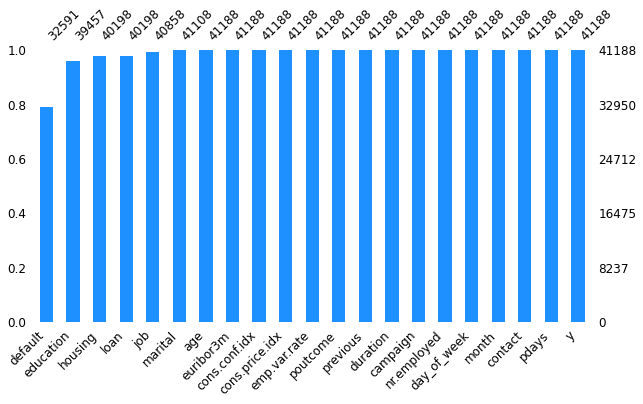

In [15]:
missingno.bar(df,color="dodgerblue", sort="ascending", figsize=(10,5), fontsize=12);

terlihat default, education, housing, loan, job, dan marital memiliki data unknown

<AxesSubplot:>

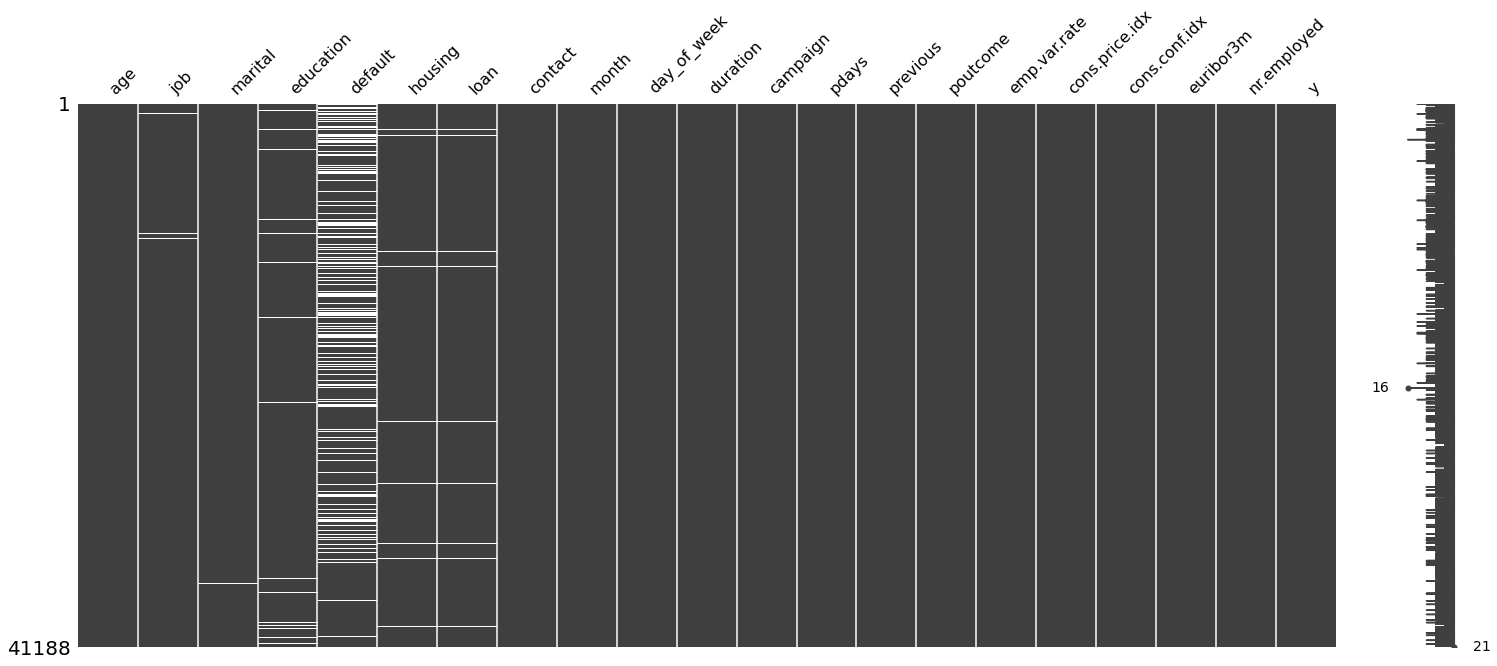

In [16]:
missingno.matrix(df)

In [17]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


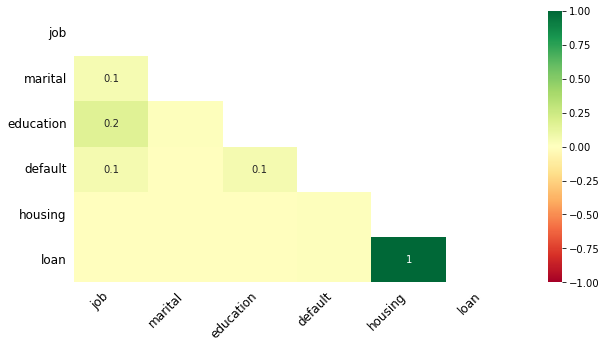

In [18]:
missingno.heatmap(df, cmap="RdYlGn", figsize=(10,5), fontsize=12);

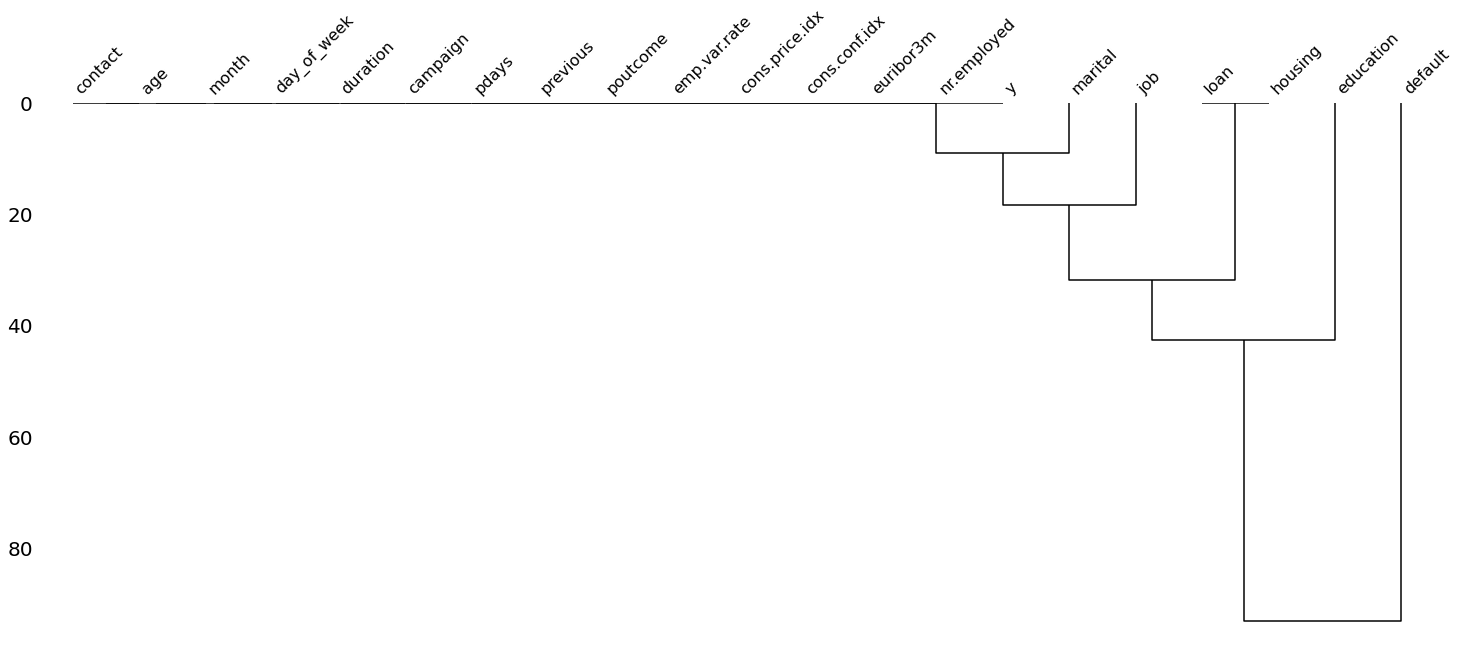

In [19]:
missingno.dendrogram(df)
plt.show()

dari matrix, heatmap dan dendogram diatas dapat disimpulkan bahwa

* data loan dan housing memiliki kekosongan yang sama dimana ini menandakan lebih baik mengisinya dengan data yang sama
* pada kolom default terdapat 20% data yang kosong
* kolom job dan kolom education terdapat korelasi diantara data yang kosongnya.

## Check Outlier

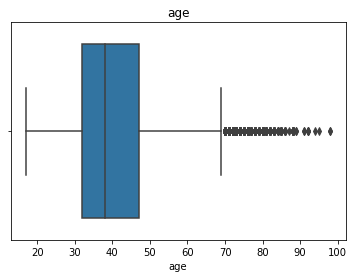

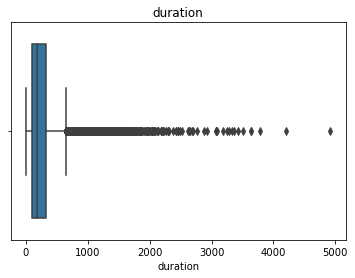

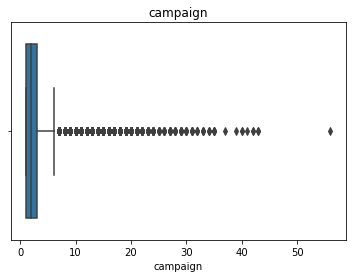

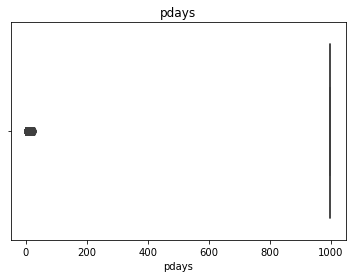

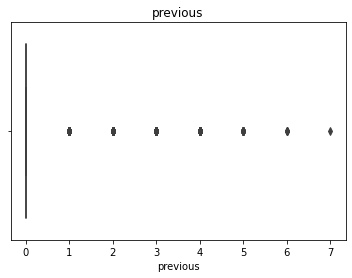

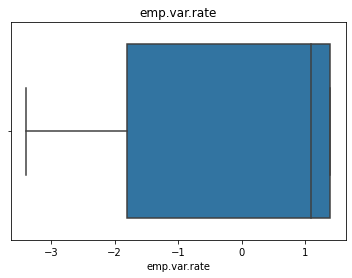

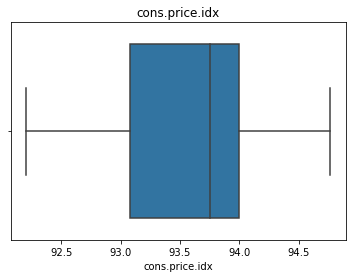

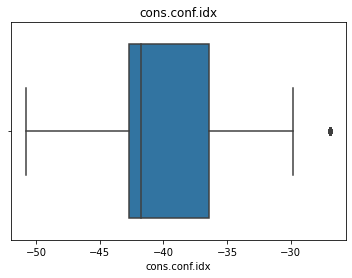

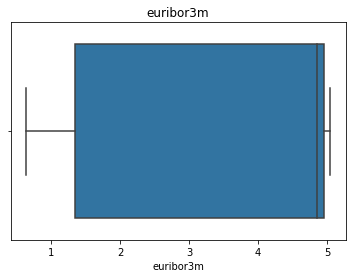

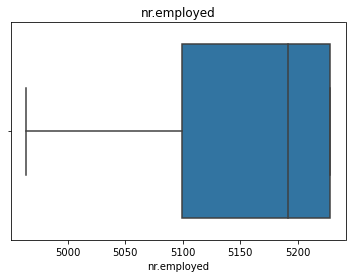

In [20]:
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# create boxplots for numerical columns
for col in num_cols:
    plt.figure()
    sns.boxplot(data=df, x=col)
    plt.title(col)


In [21]:
df['age'].unique()

array([56, 57, 37, 40, 45, 59, 41, 24, 25, 29, 35, 54, 46, 50, 39, 30, 55,
       49, 34, 52, 58, 32, 38, 44, 42, 60, 53, 47, 51, 48, 33, 31, 43, 36,
       28, 27, 26, 22, 23, 20, 21, 61, 19, 18, 70, 66, 76, 67, 73, 88, 95,
       77, 68, 75, 63, 80, 62, 65, 72, 82, 64, 71, 69, 78, 85, 79, 83, 81,
       74, 17, 87, 91, 86, 98, 94, 84, 92, 89], dtype=int64)

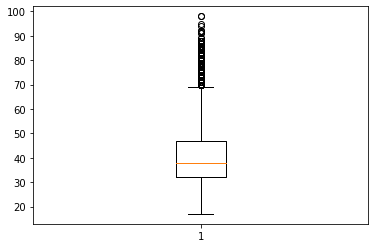

In [22]:
plt.boxplot(df['age'])
plt.show()

In [23]:
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df['age'] < lower_bound) | (df['age'] > upper_bound)]
print(f"Jumlah data oulier pada kolom Age : {len(outliers)}")


Jumlah data oulier pada kolom Age : 469


In [24]:
out_all=outliers.pivot_table(columns='age', index=['y'], aggfunc='size')
out_all['Total']=out_all.sum(axis =1)
out_all.sort_values('Total',ascending=False)

age,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,91,92,94,95,98,Total
y,,,,,,,,,,,,,,,,,,,,,,,,,,
no,28.0,32.0,21.0,21.0,17.0,13.0,16.0,7.0,13.0,7.0,13.0,12.0,6.0,9.0,4.0,8.0,3.0,NaN,13.0,NaN,2.0,1.0,1.0,1.0,NaN,248.0
yes,19.0,21.0,13.0,13.0,15.0,11.0,18.0,13.0,14.0,7.0,18.0,8.0,11.0,8.0,3.0,7.0,5.0,1.0,9.0,2.0,NaN,3.0,NaN,NaN,2.0,221.0


In [25]:
df['y'] = df['y'].replace({'yes': 1, 'no': 0})


replace data y dengan 1 = yes dan 0 = no

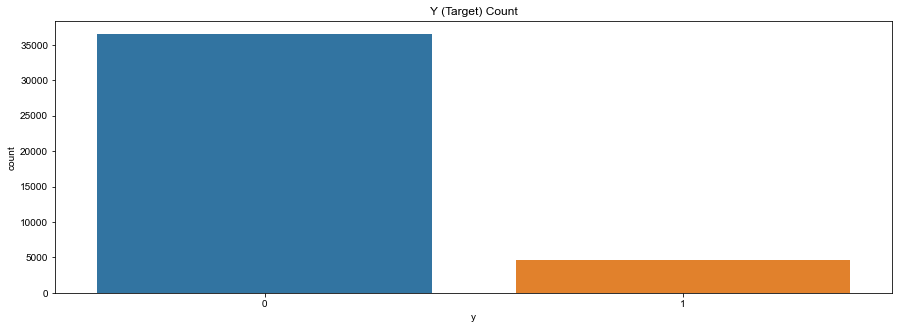

In [26]:
plt.figure(figsize=(15, 5))
sns.countplot(x='y', data=df)
sns.set(rc={'figure.figsize':(10,6)})
plt.title('Y (Target) Count')
plt.show()

Dari visualisasi kolom Target dapat dilihat bawah targetnya imbalance.

### Numerical Columns

#### Job

Text(0.5, 1.0, 'Job Count')

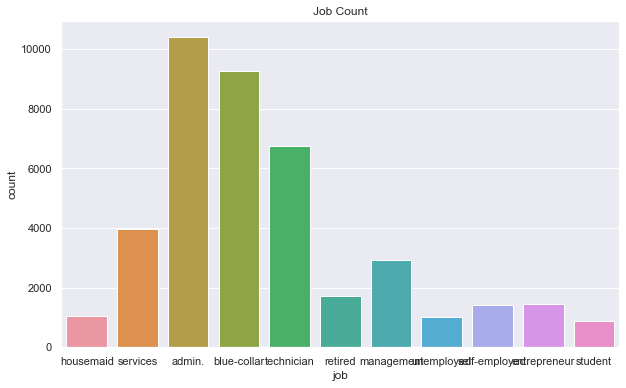

In [27]:
sns.countplot(data = df, x = 'job')
sns.set(rc={'figure.figsize':(20,8)})
plt.title('Job Count')

Text(0.5, 1.0, 'Job Count Based on Target')

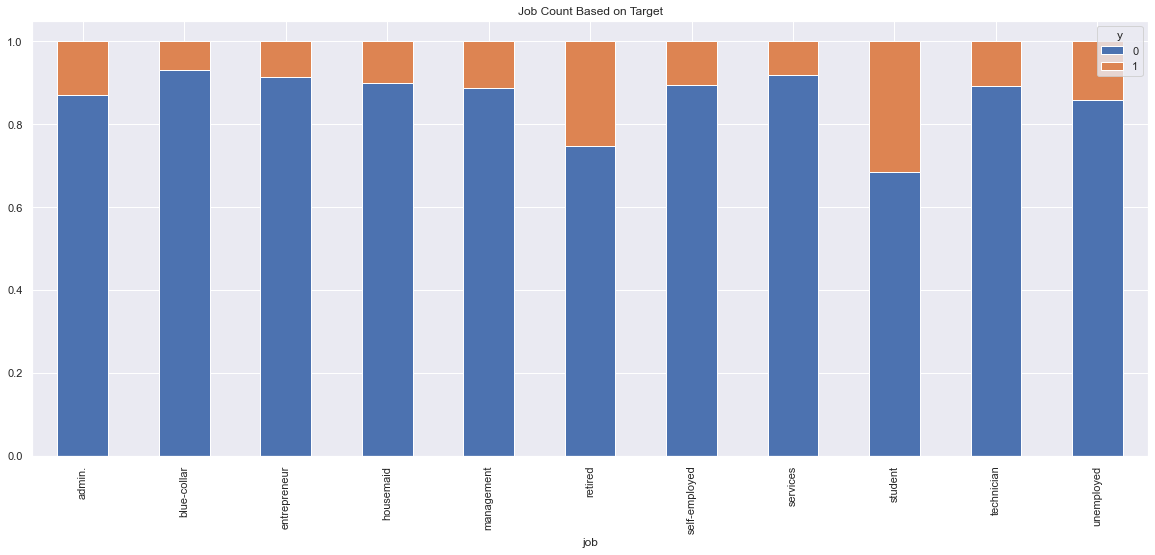

In [28]:
Job=pd.crosstab(df["job"],df['y'])
Job.div(Job.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(20,8))
plt.title('Job Count Based on Target')

Dari visualisasi diatas dapat dilihat bahwa student dan retired memiliki acceptance rate tertinggi terhadap penawaran term deposit.

#### Poutcome

Text(0.5, 1.0, 'P Outcome Count')

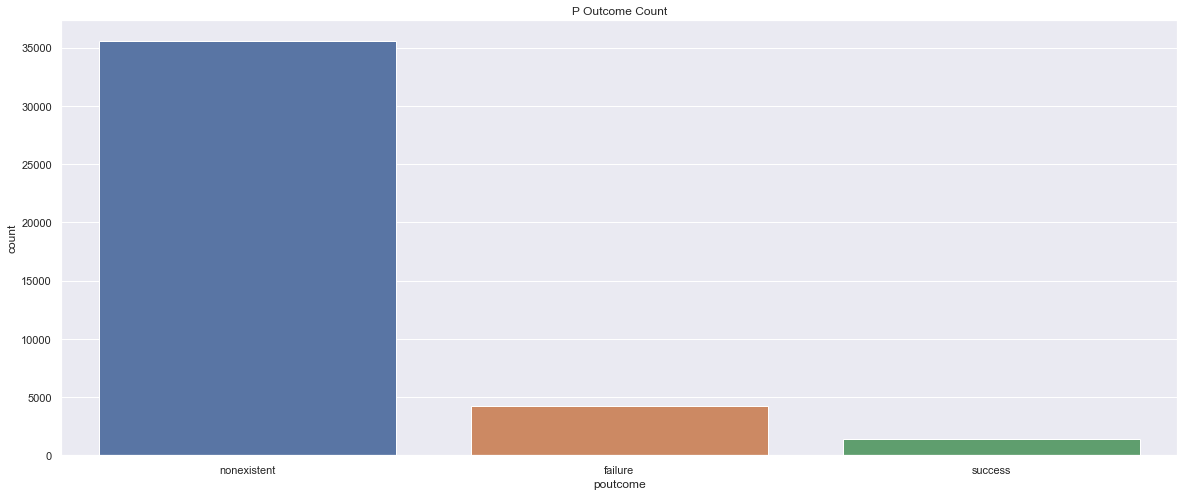

In [29]:
sns.countplot(data = df, x = 'poutcome')
sns.set(rc={'figure.figsize':(10,6)})
plt.title('P Outcome Count')

Text(0.5, 1.0, 'P Outcome Count Based on Target')

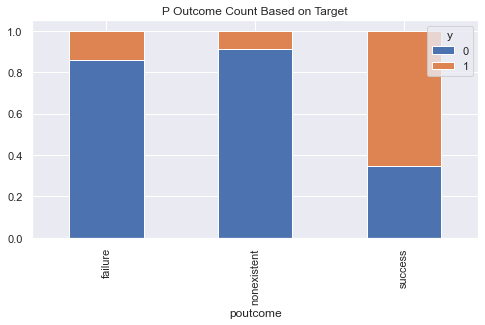

In [30]:
Poutcome=pd.crosstab(df["poutcome"],df['y'])
Poutcome.div(Poutcome.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(8,4))
sns.set(rc={'figure.figsize':(10,6)})
plt.title('P Outcome Count Based on Target')

Dari visualisasi diatas dapat dilihat bahwa mereja yang succes memiliki kemungkinan terbesar untuk melakukan term deposit.

#### Day of the week

Text(0.5, 1.0, 'Day of the Week Count')

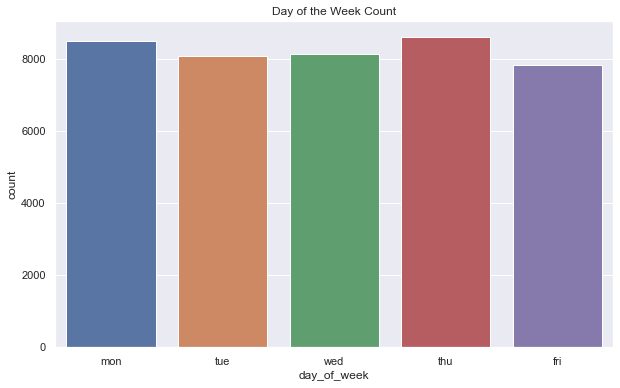

In [31]:
sns.countplot(data = df, x = 'day_of_week')
sns.set(rc={'figure.figsize':(10,6)})
plt.title('Day of the Week Count')

Text(0.5, 1.0, 'Day of the Week Count Based on Target')

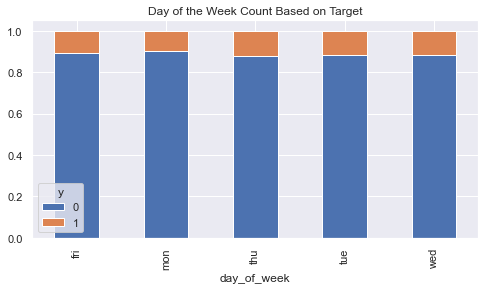

In [32]:
Day=pd.crosstab(df["day_of_week"],df['y'])
Day.div(Day.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(8,4))
sns.set(rc={'figure.figsize':(10,6)})
plt.title('Day of the Week Count Based on Target')

dari visualisasi diatas dapat dilihat bahwa penawaran hanya dilakukan di hari kerja

#### Month

Text(0.5, 1.0, 'Month Count')

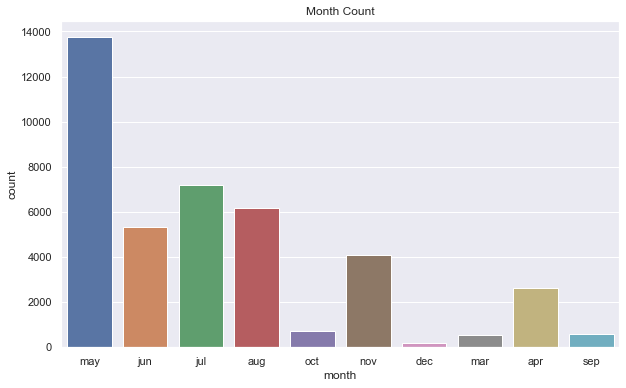

In [33]:
sns.countplot(data = df, x = 'month')
sns.set(rc={'figure.figsize':(10,6)})
plt.title('Month Count')

Text(0.5, 1.0, 'Month Count Based on Target')

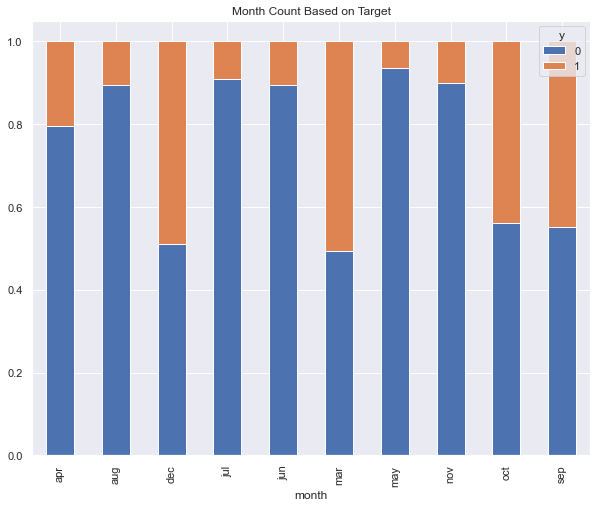

In [34]:
Month=pd.crosstab(df["month"],df['y'])
Month.div(Month.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(10,8))
plt.title('Month Count Based on Target')

dari visualisasi diatas dapat dilihat bahwa proses penawaran paling banyak dilakukan pada bulan Mei, tetapi kemungkinan terbesar seorang nasabah melakukan pembukaan rekening terdapat pada bulan Maret, Desember, Oktober dan September

#### Contact

Text(0.5, 1.0, 'Contact Count')

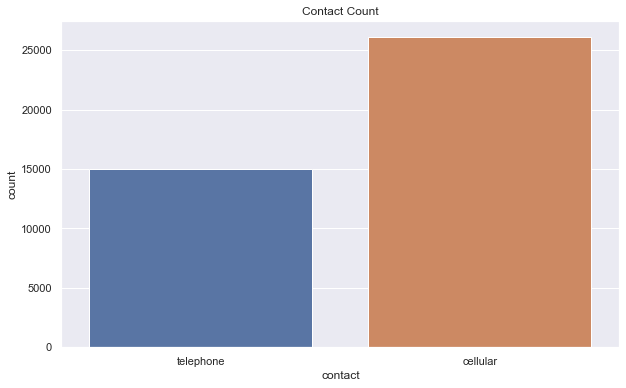

In [35]:
sns.countplot(data = df, x = 'contact')
sns.set(rc={'figure.figsize':(10,6)})
plt.title('Contact Count')

Text(0.5, 1.0, 'Contact Count Based on Target')

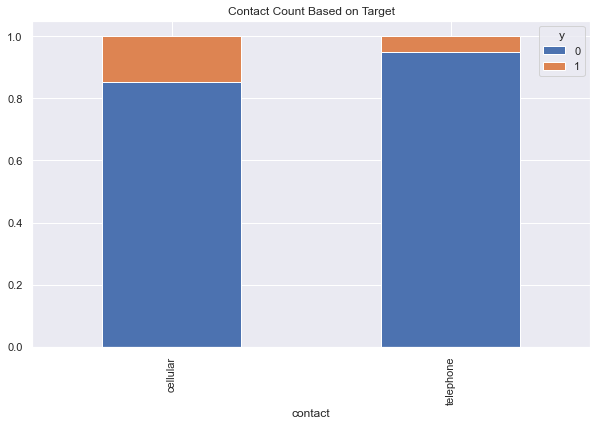

In [36]:
Contact=pd.crosstab(df["contact"],df['y'])
Contact.div(Contact.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
sns.set(rc={'figure.figsize':(10,6)})
plt.title('Contact Count Based on Target')

#### Marital

Text(0.5, 1.0, 'Marital Count')

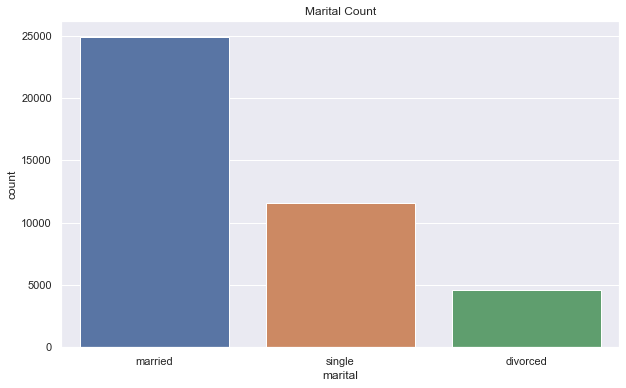

In [37]:
sns.countplot(data = df, x = 'marital')
sns.set(rc={'figure.figsize':(10,6)})
plt.title('Marital Count')

Text(0.5, 1.0, 'Marital Count Based on Target')

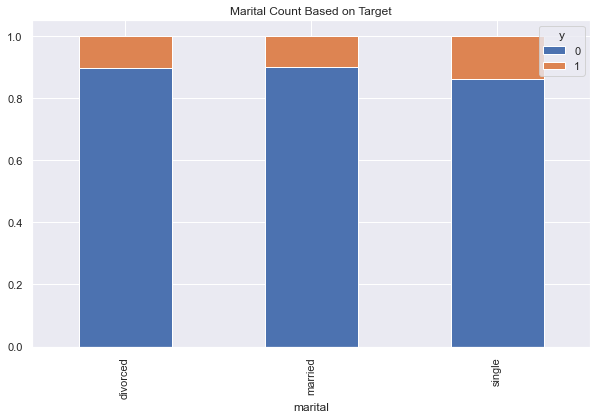

In [38]:
Marital=pd.crosstab(df["marital"],df['y'])
Marital.div(Marital.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
sns.set(rc={'figure.figsize':(10,6)})
plt.title('Marital Count Based on Target')

Nasabah yang paling sering dihubungi yang Married, tetapi Nasabah Single memiliki kemungkinan terbesar untuk melakukan pembukaan rekening deposito

#### Loan

Text(0.5, 1.0, 'Loan Count')

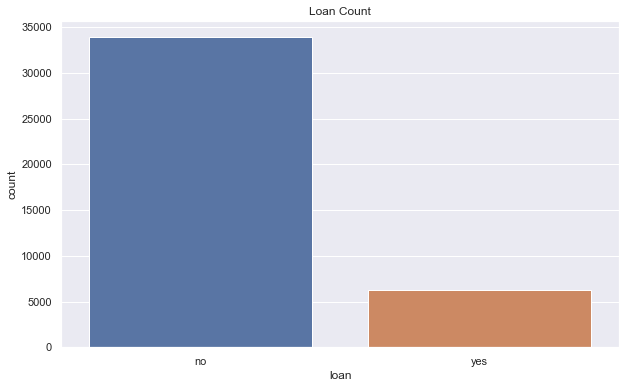

In [39]:
sns.countplot(data = df, x = 'loan')
sns.set(rc={'figure.figsize':(10,6)})
plt.title('Loan Count')

Text(0.5, 1.0, 'Loan Count Based on Target')

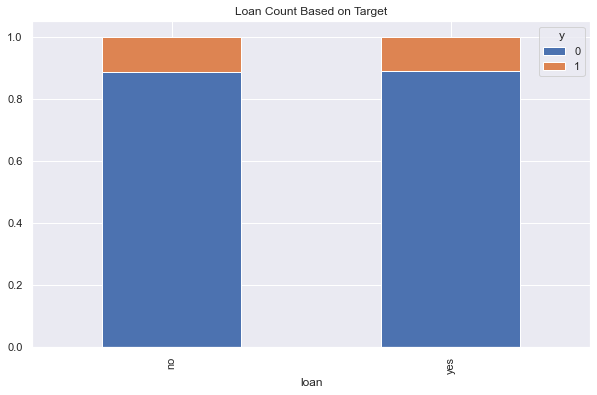

In [40]:
Loan=pd.crosstab(df["loan"],df['y'])
Loan.div(Loan.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
sns.set(rc={'figure.figsize':(8,4)})
plt.title('Loan Count Based on Target')

Nasabah yang lebih sering dihubungi adalah mereka yang tidak memiliki loan pada bank, meskipun ada atau tidak adanya loan tidak terlalu mempengaruhi rasio pembukaan rekening deposito.

#### Housing

Text(0.5, 1.0, 'Housing Count')

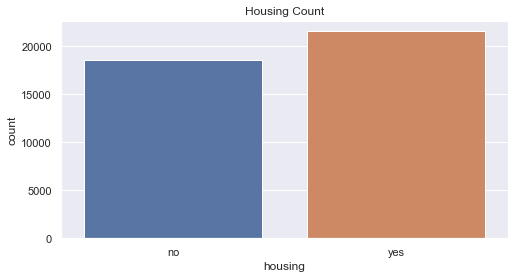

In [41]:
sns.countplot(data = df, x = 'housing')
sns.set(rc={'figure.figsize':(8,4)})
plt.title('Housing Count')

Text(0.5, 1.0, 'Housing Count Based on Target')

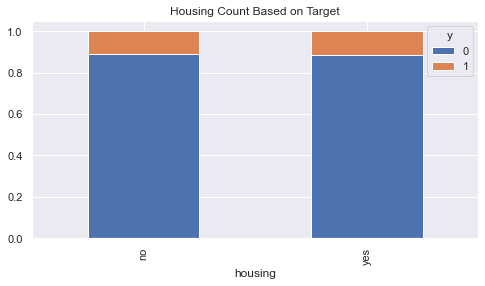

In [42]:
Housing=pd.crosstab(df["housing"],df['y'])
Housing.div(Housing.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
sns.set(rc={'figure.figsize':(8,4)})
plt.title('Housing Count Based on Target')

Nasabah yang lebih sering dihubungi adalah mereka yang memiliki housing loan pada bank, meskipun ada atau tidak adanya housing loan tidak terlalu mempengaruhi rasio pembukaan rekening deposito.

#### Default

Text(0.5, 1.0, 'Default Count')

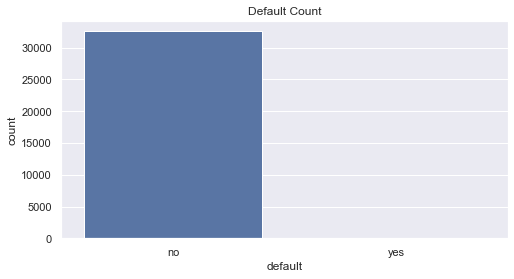

In [43]:
sns.countplot(data = df, x = 'default')
sns.set(rc={'figure.figsize':(8,4)})
plt.title('Default Count')

Text(0.5, 1.0, 'Default Count Based on Target')

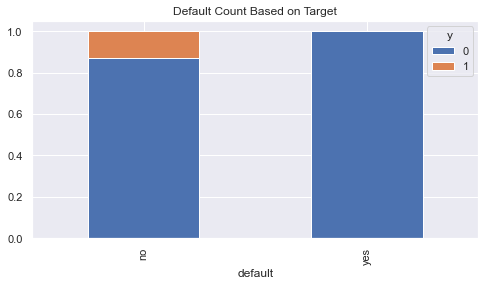

In [44]:
Default=pd.crosstab(df["default"],df['y'])
Default.div(Default.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
sns.set(rc={'figure.figsize':(8,4)})
plt.title('Default Count Based on Target')

Bagi yang default nya memiliki value yes tidak ada yang melakukan pembukaan rekening deposito

#### Education

Text(0.5, 1.0, 'Education')

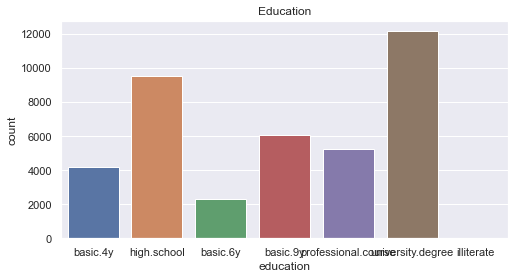

In [45]:
sns.countplot(data = df, x = 'education')
sns.set(rc={'figure.figsize':(20,8)})
plt.title('Education')

Text(0.5, 1.0, 'Education Count Based on Target')

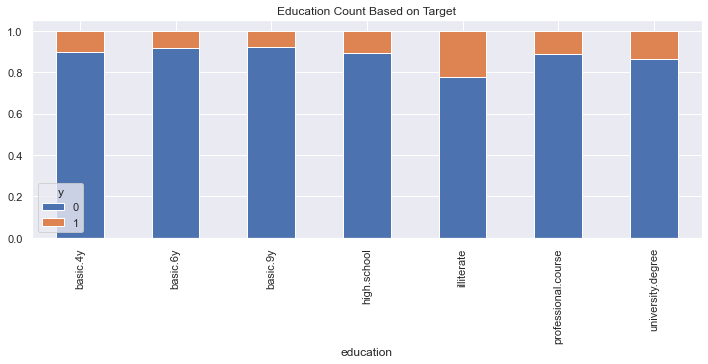

In [46]:
Default=pd.crosstab(df["education"],df['y'])
Default.div(Default.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(12,4))
plt.title('Education Count Based on Target')

Dari visualisasi data dapat dilihat bahwa illiterate memiliki kemungkinan terbesar dalam pembukaan rekening term deposit.

### Numerical Features

In [47]:
num_column = []
lst_nunique = []
for cat in df.columns:
    if df[cat].dtype != 'object' and cat != 'y' :
        num_column.append(cat)
        lst_nunique.append([cat,df[cat].nunique()])

df_num = pd.DataFrame(columns=['Column','f Unique'],data =lst_nunique)

df_num


,Column,f Unique
0,age,78
1,duration,1544
2,campaign,42
3,pdays,27
4,previous,8
5,emp.var.rate,10
6,cons.price.idx,26
7,cons.conf.idx,26
8,euribor3m,316
9,nr.employed,11


#### Number of Employees

Text(0.5, 1.0, 'Number of Employees Distribution based on target')

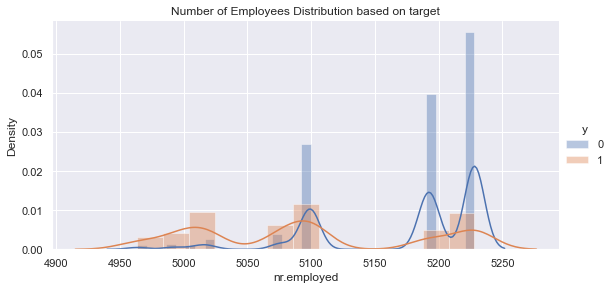

In [48]:
sns.FacetGrid(df, hue='y',height=4, aspect=2).map(sns.distplot, 'nr.employed').add_legend()
plt.title('Number of Employees Distribution based on target')

Text(0.5, 1.0, 'Number of Employees Count')

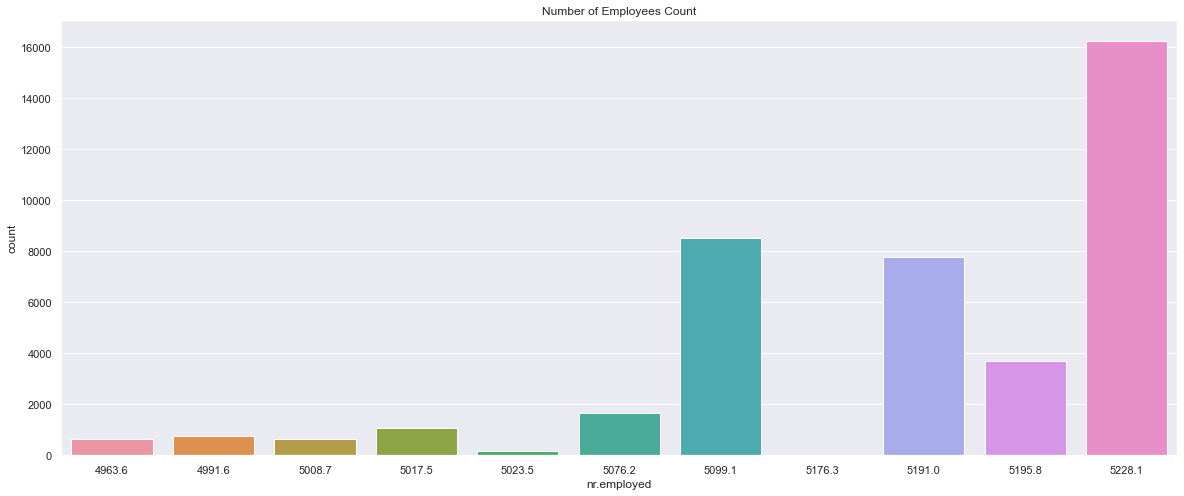

In [49]:
sns.countplot(data = df , x = 'nr.employed')
plt.title('Number of Employees Count')

Text(0.5, 1.0, 'Number of Employees Count based on Target')

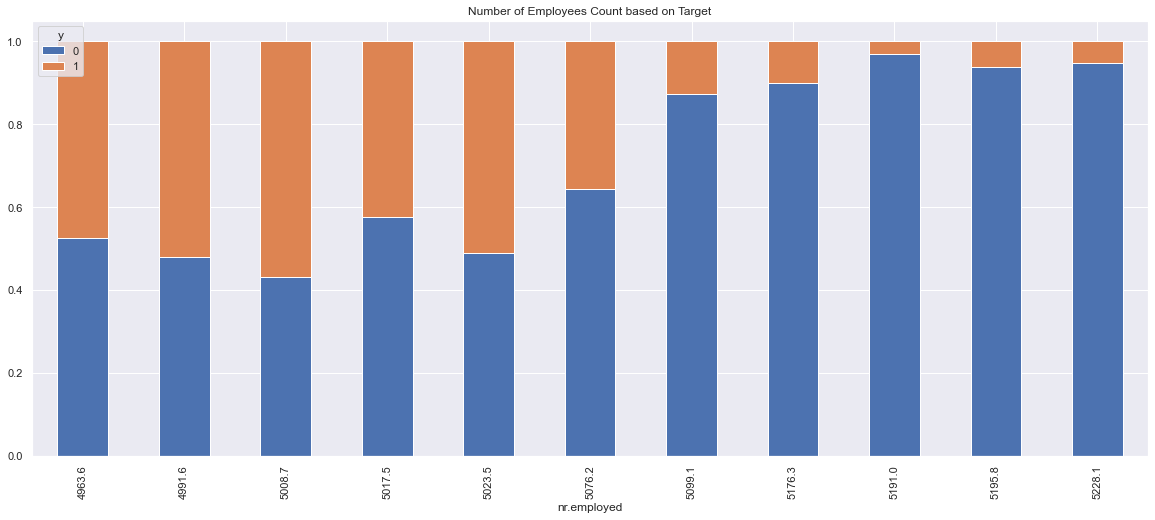

In [50]:
NE=pd.crosstab(df["nr.employed"],df['y'])
NE.div(NE.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
sns.set(rc={'figure.figsize':(20,8)})
plt.title('Number of Employees Count based on Target')

#### Euro Interbank Offered Rate

Text(0.5, 1.0, 'Euribor3m Distribution based on target')

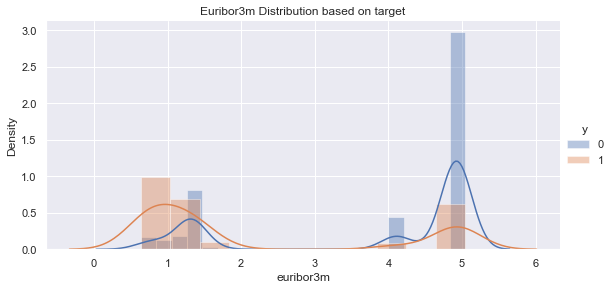

In [51]:
sns.FacetGrid(df, hue='y',height=4, aspect=2).map(sns.distplot, 'euribor3m').add_legend()
plt.title('Euribor3m Distribution based on target')

#### Consumer Confidence

Text(0.5, 1.0, 'Consumer Confidence Distribution based on target')

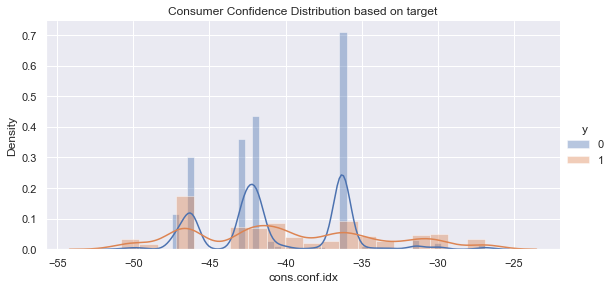

In [52]:
sns.FacetGrid(df, hue='y',height=4, aspect=2).map(sns.distplot, 'cons.conf.idx').add_legend()
plt.title('Consumer Confidence Distribution based on target')

In [53]:
df['cons.conf.idx'].unique()

array([-36.4, -41.8, -42.7, -36.1, -40.4, -42. , -45.9, -50. , -47.1,
       -46.2, -40.8, -33.6, -31.4, -29.8, -26.9, -30.1, -33. , -34.8,
       -34.6, -40. , -39.8, -40.3, -38.3, -37.5, -49.5, -50.8])

#### Consumer Price

Text(0.5, 1.0, 'Consumer Confidence Index Distribution based on target')

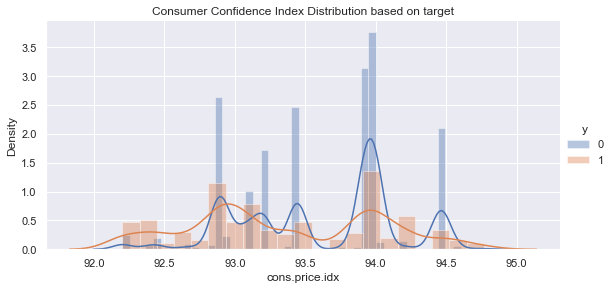

In [54]:
sns.FacetGrid(df, hue='y',height=4, aspect=2).map(sns.distplot, 'cons.price.idx').add_legend()
plt.title('Consumer Confidence Index Distribution based on target')

#### Employment Variation Rate

Text(0.5, 1.0, 'Employee Variation Rate Distribution based on target')

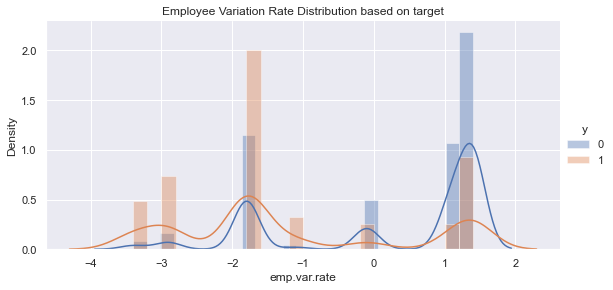

In [55]:
sns.FacetGrid(df, hue='y',height=4, aspect=2).map(sns.distplot, 'emp.var.rate').add_legend()
plt.title('Employee Variation Rate Distribution based on target')

In [56]:
df['emp.var.rate'].unique()

array([ 1.1,  1.4, -0.1, -0.2, -1.8, -2.9, -3.4, -3. , -1.7, -1.1])

#### Previous

Text(0.5, 1.0, 'Previous Count')

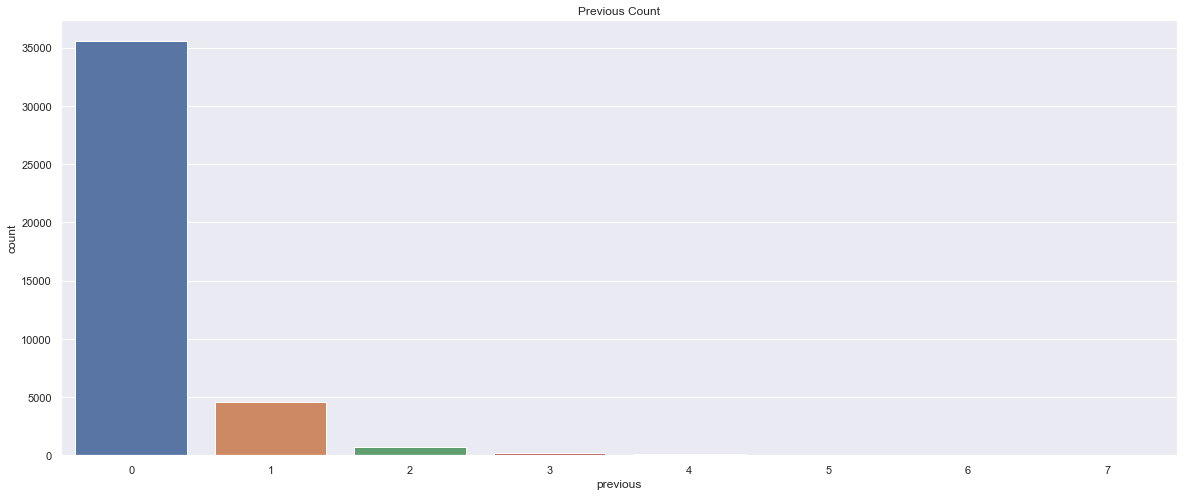

In [57]:
sns.countplot(data = df , x = 'previous')
sns.set(rc={'figure.figsize':(8,4)})
plt.title('Previous Count')

Text(0.5, 1.0, 'Previous Count based on Target')

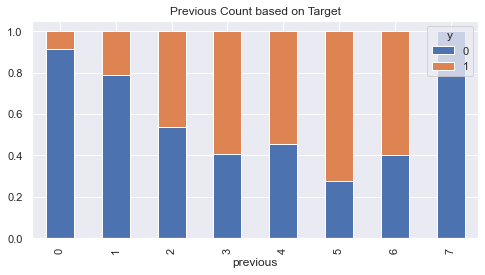

In [58]:
Previous=pd.crosstab(df["previous"],df['y'])
Previous.div(Previous.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
sns.set(rc={'figure.figsize':(10,6)})
plt.title('Previous Count based on Target')

Dari visualisasi diatas dilihat bahwa maksimal pihak bank melakukan 7 kali kontak sebelum kampanye pembukaan term deposit terhadap seorang nasabah.

#### pdays

Text(0.5, 1.0, 'Pdays Box Plot')

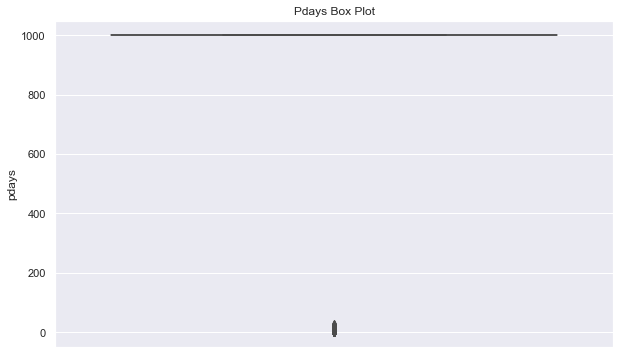

In [59]:
sns.boxplot(data = df , y = 'pdays')
plt.title('Pdays Box Plot')

Text(0.5, 1.0, 'Pdays Count')

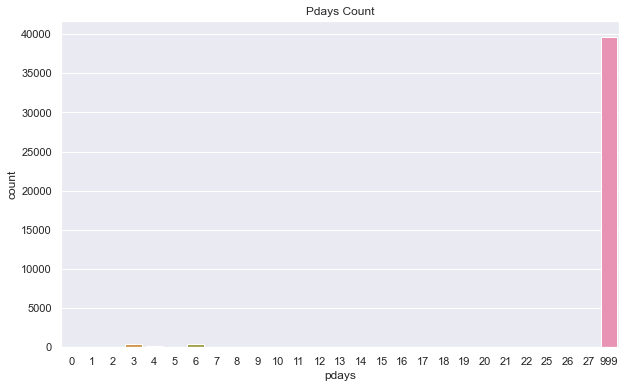

In [60]:
sns.countplot(data = df , x = 'pdays')
sns.set(rc={'figure.figsize':(8,4)})
plt.title('Pdays Count')

Text(0.5, 1.0, 'Pdays Count based on Target')

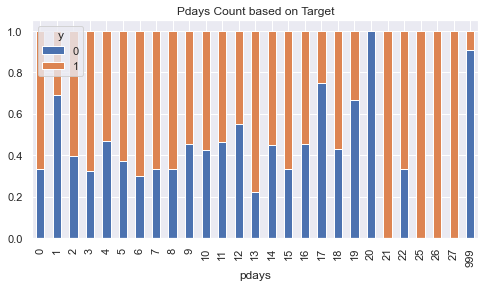

In [61]:
Previous=pd.crosstab(df["pdays"],df['y'])
Previous.div(Previous.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
sns.set(rc={'figure.figsize':(12,6)})
plt.title('Pdays Count based on Target')

In [62]:
df['pdays'].unique()

array([999,   6,   4,   3,   5,   1,   0,  10,   7,   8,   9,  11,   2,
        12,  13,  14,  15,  16,  21,  17,  18,  22,  25,  26,  19,  27,
        20], dtype=int64)

Dari visualisasi diatas dapat dilihat bahwa kolom pdays memiliki lompatan nilai yang jauh dari 27 ke 999, hal ini dikarenakan untuk 999 merupakan label untuk nasabah yang belum menerima penawaran sebelumnya.

#### Campaign

Text(0.5, 1.0, 'Campaign Boxplot')

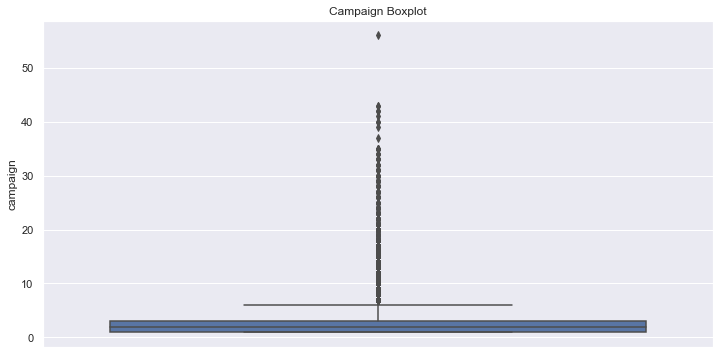

In [63]:
sns.boxplot(data = df , y = 'campaign')
plt.title('Campaign Boxplot')

Text(0.5, 1.0, 'Pdays Count')

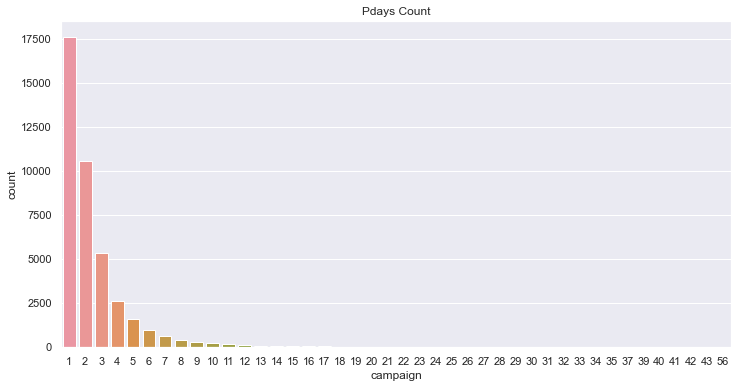

In [64]:
sns.countplot(data = df , x = 'campaign')
sns.set(rc={'figure.figsize':(8,4)})
plt.title('Pdays Count')

Text(0.5, 1.0, 'Pdays count based on target')

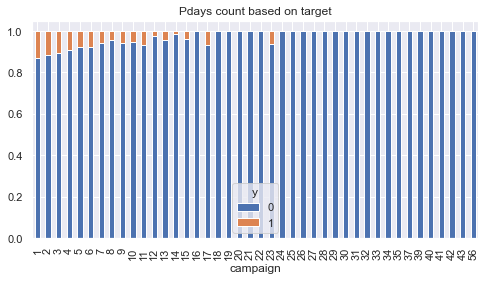

In [65]:
Previous=pd.crosstab(df["campaign"],df['y'])
Previous.div(Previous.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
sns.set(rc={'figure.figsize':(18,8)})
plt.title('Pdays count based on target')

#### Age

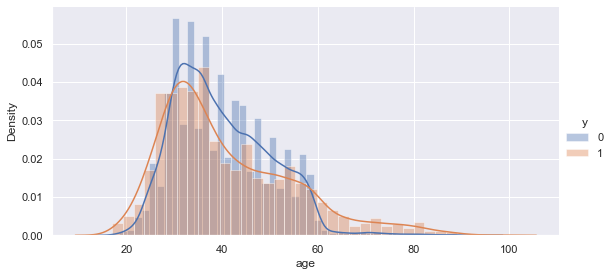

In [66]:
sns.FacetGrid(df, hue='y',height=4,aspect=2).map(sns.distplot, 'age').add_legend()

#### Duration

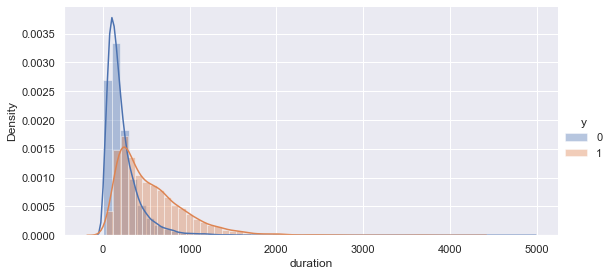

In [67]:
sns.FacetGrid(df, hue='y',height=4,aspect=2).map(sns.distplot, 'duration').add_legend()

Semakin lama durasi maka semakin besar probabilitas seorang nasabah melakukan pembukaan rekening term deposit.

#

## Preprocessing

In [68]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


### Handling Duplicate

In [69]:
df.drop_duplicates(keep='last',inplace=True)

Menghapus data duplikat dengan menyimpan hanya 1 kemunculannya, yaitu yang terakhir.

In [70]:
df[df.duplicated(keep=False)]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y


### Handling Missing Values

In [71]:
df.drop(columns = 'default',inplace=True)

In [72]:
df.dropna(inplace=True)

In [73]:
df.shape

(38234, 20)

### Feature Engineering

In [74]:
df.drop(columns= ['duration'],inplace=True)

#### Education

basic education di grouping menjadi basic education.  https://eurydice.eacea.ec.europa.eu/national-education-systems/portugal/organisation-education-system-and-its-structure

In [75]:
lst=['basic.9y','basic.6y','basic.4y']
for i in lst:
    df.loc[df['education'] == i, 'education'] = "basic.education"

df['education'].value_counts()

basic.education        12061
university.degree      11817
high.school             9241
professional.course     5097
illiterate                18
Name: education, dtype: int64

<AxesSubplot:xlabel='education', ylabel='count'>

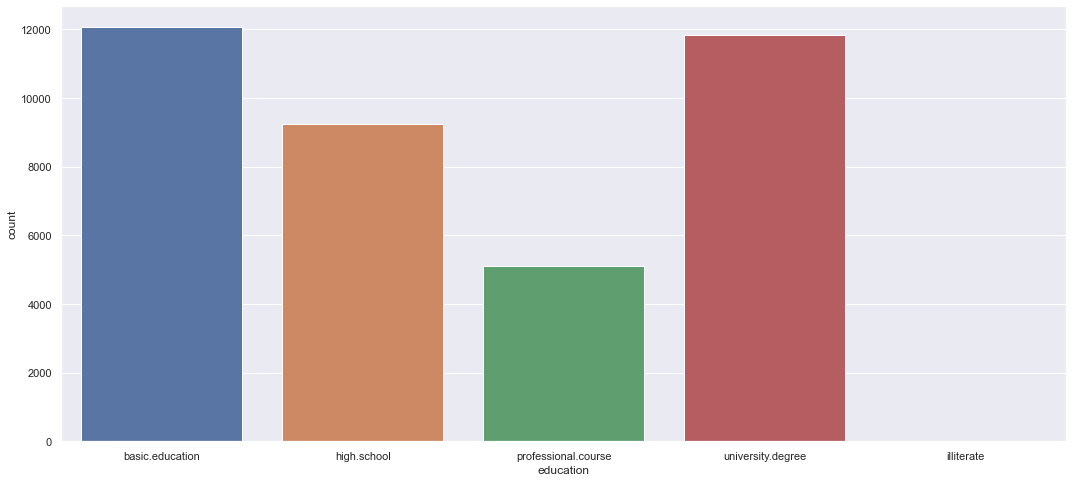

In [76]:
sns.countplot(data = df, x = 'education')

<AxesSubplot:xlabel='education'>

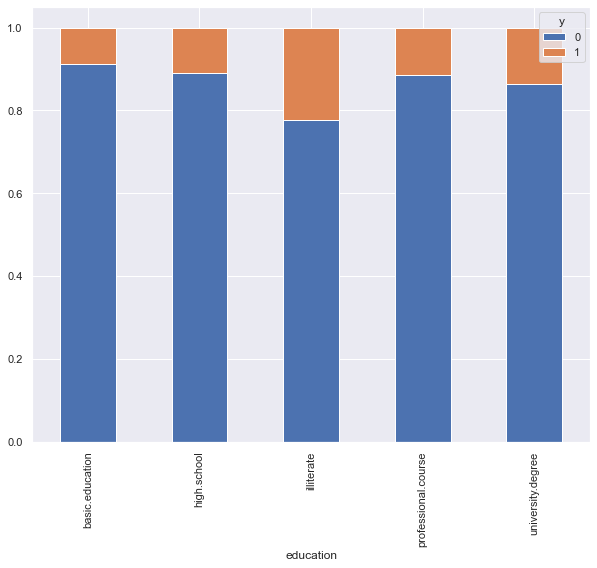

In [77]:
Education=pd.crosstab(df["education"],df['y'])
Education.div(Education.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(10,8))

Terlihat dari tiap edukasinya bahwa yang illiterate memiliki kemungkinan terbesar untuk membuka deposito

#### Pdays

In [78]:
df['pdays'] = ["Contacted" if v != 999 else 'Not Contacted' for v in df['pdays']]

Merubah nilai 999 menjadi Not Contacted dan data lainnya menjadi Contacted

In [79]:
df['pdays'].value_counts()

Not Contacted    36868
Contacted         1366
Name: pdays, dtype: int64

<AxesSubplot:xlabel='pdays', ylabel='count'>

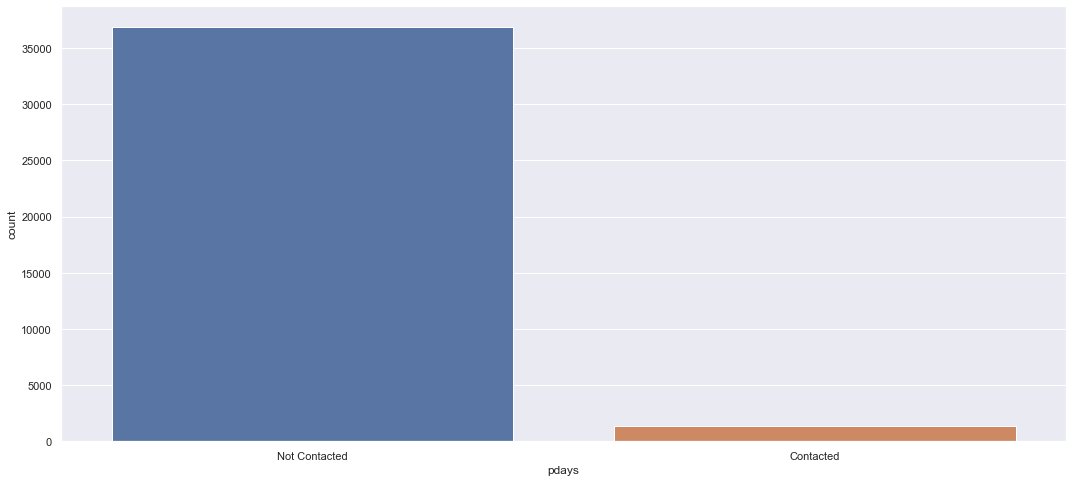

In [80]:
sns.countplot(data = df, x = 'pdays')

Text(0.5, 1.0, 'Pdays count based on target')

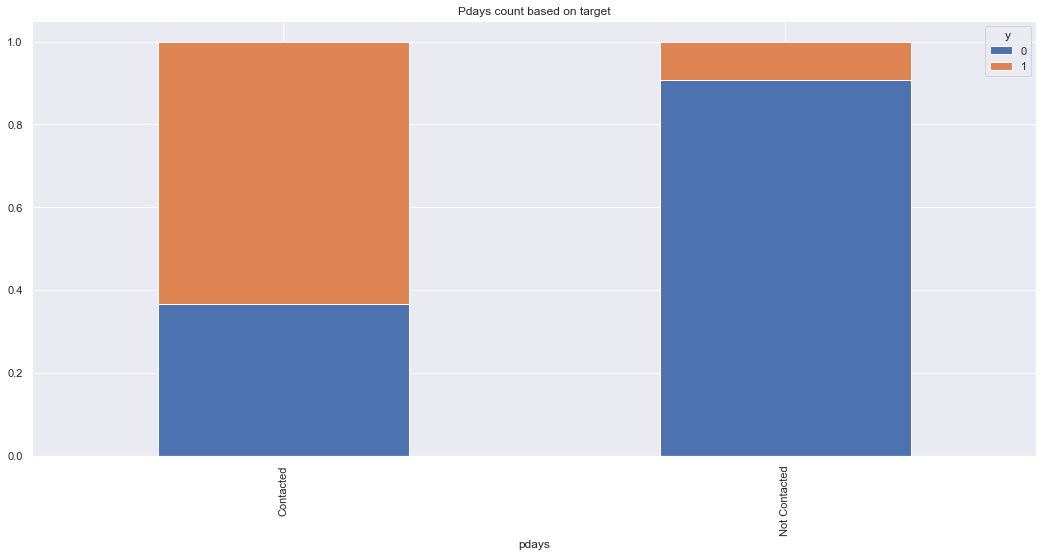

In [81]:
Previous=pd.crosstab(df["pdays"],df['y'])
Previous.div(Previous.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
sns.set(rc={'figure.figsize':(18,8)})
plt.title('Pdays count based on target')

Menurut Visualisasi diatas mereka yang telah dikontak memiliki kemungkinan lebih besar untuk membuka rekening term deposit.

#### Campaign

Text(0.5, 1.0, 'Campaign Boxplot with Outlier')

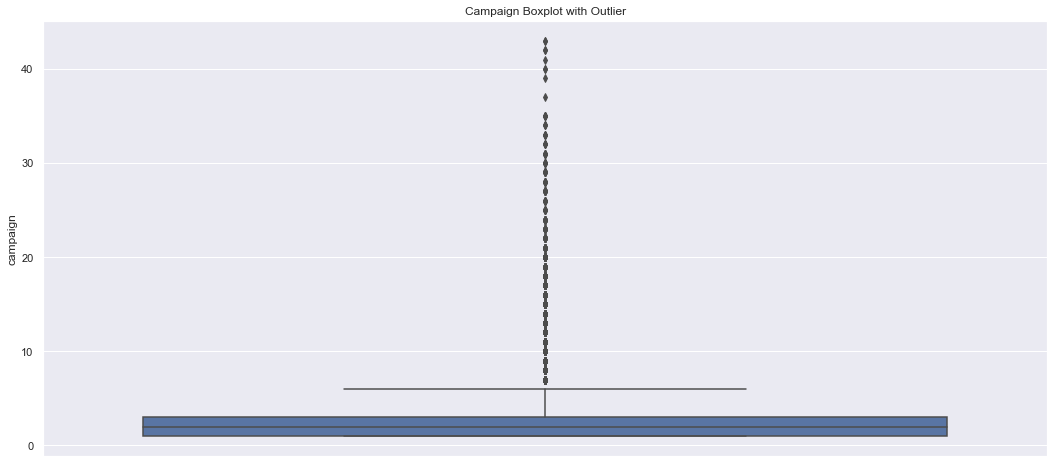

In [82]:
sns.boxplot(data=df , y = 'campaign')
plt.title('Campaign Boxplot with Outlier')

In [83]:
Q1 = df['campaign'].quantile(0.25)
Q3 = df['campaign'].quantile(0.75)
IQR = Q3 - Q1     

filter = (df['campaign'] >= Q1 - 1.5 * IQR) & (df['campaign'] <= Q3 + 1.5 *IQR)
df=df.loc[filter]

Text(0.5, 1.0, 'Campaign Boxplot without Outlier')

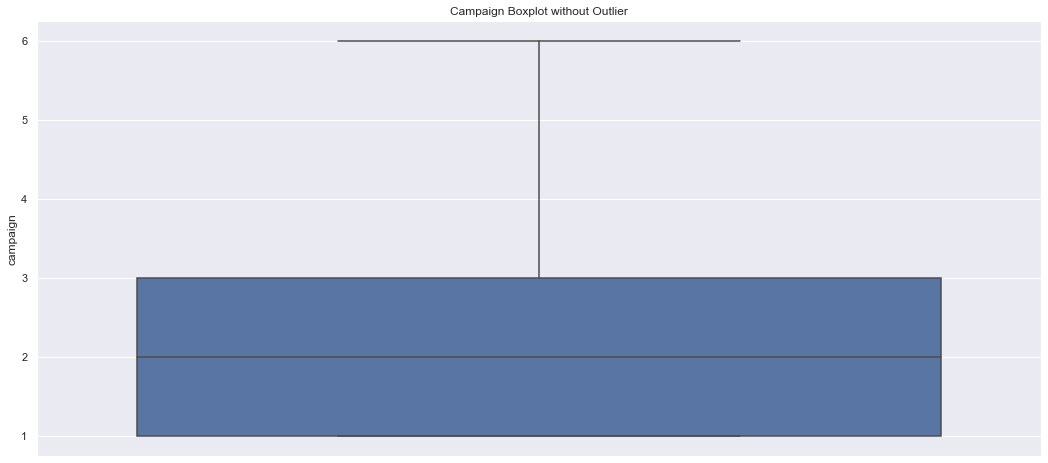

In [84]:
sns.boxplot(data = df , y = 'campaign')
plt.title('Campaign Boxplot without Outlier')

<AxesSubplot:xlabel='campaign', ylabel='count'>

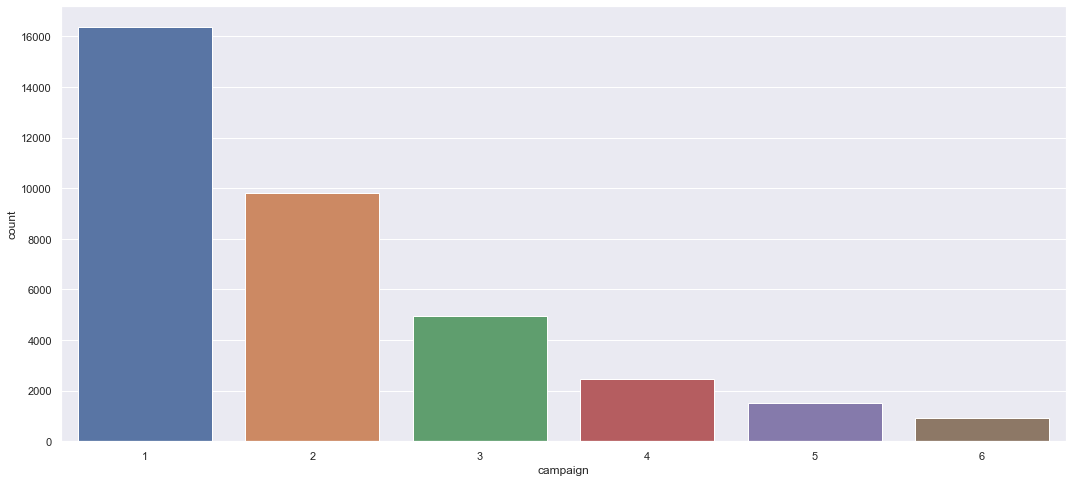

In [85]:
sns.countplot(data = df, x= 'campaign')

Text(0.5, 1.0, 'Campaign count based on target')

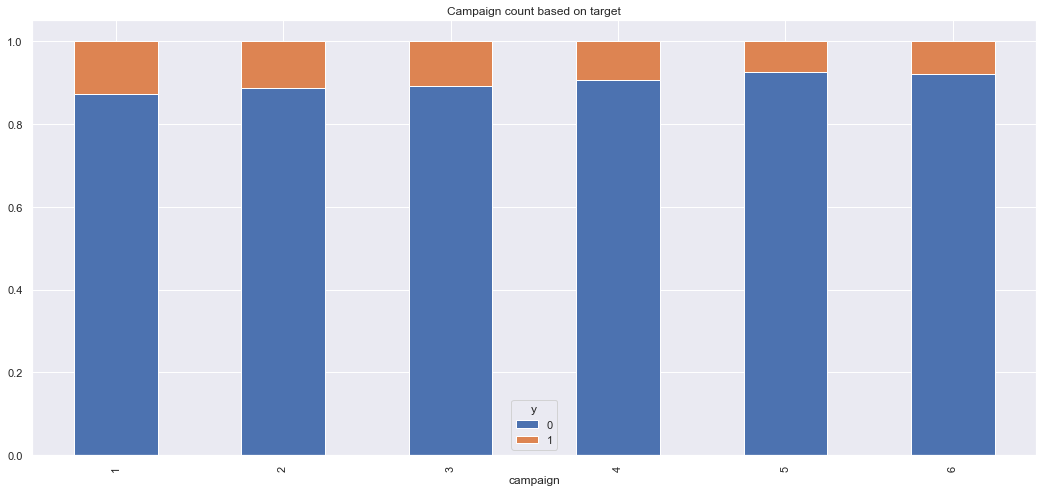

In [86]:
Previous=pd.crosstab(df["campaign"],df['y'])
Previous.div(Previous.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
sns.set(rc={'figure.figsize':(18,8)})
plt.title('Campaign count based on target')

In [87]:
df['campaign'] = df['campaign'].astype('O')

Data outlier pada kolom campaign dibuang karena kita ingin meningkatkan jumlah penerimaan penawaran pembukaan rekening term deposit, dengan meminimalkan jumlah kontak penawaran yang dibutuhkan

#### Age

Melakuakan Grouping berdasarka rentang usia

In [88]:
df['age'].nunique()

77

In [89]:
#Grouping by Range
def age(dataframe):
    q1 = 20
    q2 = 30
    q3 = 40
    q4 = 50
    q5 = 60
    q6 = 70
    
    dataframe.loc[(dataframe['age'] < q1), 'age'] = 1
    dataframe.loc[(dataframe['age'] >= q1) & (dataframe['age'] < q2), 'age'] = 2
    dataframe.loc[(dataframe['age'] >= q2) & (dataframe['age'] < q3), 'age'] = 3
    dataframe.loc[(dataframe['age'] >= q3) & (dataframe['age'] < q4), 'age'] = 4
    dataframe.loc[(dataframe['age'] >= q4) & (dataframe['age'] < q5), 'age'] = 5
    dataframe.loc[(dataframe['age'] >= q5) & (dataframe['age'] < q6), 'age'] = 6
    dataframe.loc[(dataframe['age'] >= q6), 'age'] = 7
     
    return dataframe
age(df)

df.head(5)

,age,job,marital,education,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,5,housemaid,married,basic.education,no,no,telephone,may,mon,1,Not Contacted,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,5,services,married,high.school,no,no,telephone,may,mon,1,Not Contacted,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,3,services,married,high.school,yes,no,telephone,may,mon,1,Not Contacted,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,4,admin.,married,basic.education,no,no,telephone,may,mon,1,Not Contacted,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,5,services,married,high.school,no,yes,telephone,may,mon,1,Not Contacted,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [90]:
df['age'] = df['age'].astype('O')

<AxesSubplot:xlabel='age'>

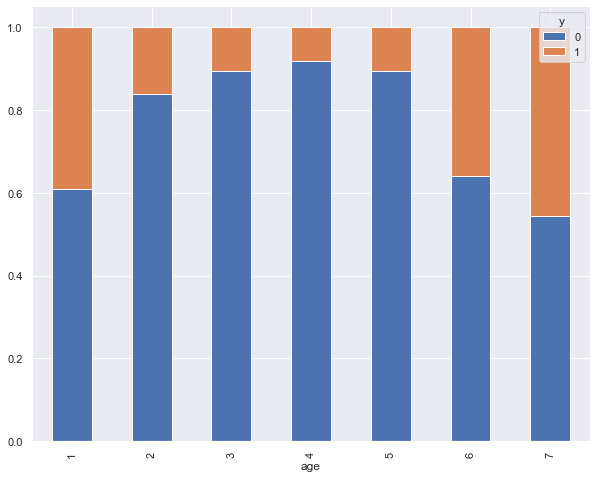

In [91]:
Age=pd.crosstab(df["age"],df['y'])
Age.div(Age.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(10,8))

Berdasarkan visualisi dapat dilihat bawah rentang usia dibawah 20 dan diatas 60 memiliki kemungkinan paling besar untuk melakukan pembukaan rekening deposito.

#### Encoding

In [92]:
lst_object = []

for i in df.columns:
    if df[i].dtype == 'O':
        lst_object.append([i,df[i].nunique(),list(df[i].drop_duplicates().sample(2).values)])
        
pd.DataFrame(data=lst_object,columns=['Columns', 'N Unique','Unique Sample']).sort_values(by=['N Unique']).reset_index()

,index,Columns,N Unique,Unique Sample
0,4,housing,2,"[no, yes]"
1,5,loan,2,"[no, yes]"
2,6,contact,2,"[cellular, telephone]"
3,10,pdays,2,"[Not Contacted, Contacted]"
4,2,marital,3,"[single, divorced]"
5,11,poutcome,3,"[nonexistent, success]"
6,3,education,5,"[high.school, basic.education]"
7,8,day_of_week,5,"[wed, thu]"
8,9,campaign,6,"[2, 3]"
9,0,age,7,"[6, 3]"


##### 

In [93]:
# Housing
df['housing'] = df['housing'].replace({'no':0,'yes':1})

# Loan
df['loan'] = df['loan'].replace({'no':0,'yes':1})

# Pdays
df['pdays'] = df['pdays'].replace({'Not Contacted':0,'Contacted':1})

In [94]:
df['education'].unique()

array(['basic.education', 'high.school', 'professional.course',
       'university.degree', 'illiterate'], dtype=object)

In [95]:
# Education
df['education'] = df['education'].replace({'illiterate':0,
                                           'basic.education':1,
                                           'high.school':2,
                                           'university.degree':3,
                                           'professional.course':4})


In [96]:
# Month
month_encoder = df['month'].value_counts().to_dict()
df['month'] = df['month'].map(month_encoder)

In [97]:
# Job
job_encoder = df['job'].value_counts().to_dict()
df['job'] = df['job'].map(job_encoder)

In [98]:
df = pd.get_dummies(df)

In [99]:
df.head()

,job,education,housing,loan,month,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_1,age_2,age_3,age_4,age_5,age_6,age_7,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,campaign_1,campaign_2,campaign_3,campaign_4,campaign_5,campaign_6,poutcome_failure,poutcome_nonexistent,poutcome_success
0,920,1,0,0,12177,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0
1,3503,2,0,0,12177,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0
2,3503,2,1,0,12177,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0
3,9333,1,0,0,12177,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0
4,3503,2,0,1,12177,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0


In [100]:
df.shape

(36014, 39)

In [101]:
df

,job,education,housing,loan,month,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_1,age_2,age_3,age_4,age_5,age_6,age_7,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,campaign_1,campaign_2,campaign_3,campaign_4,campaign_5,campaign_6,poutcome_failure,poutcome_nonexistent,poutcome_success
0,920,1,0,0,12177,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0
1,3503,2,0,0,12177,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0
2,3503,2,1,0,12177,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0
3,9333,1,0,0,12177,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0
4,3503,2,0,1,12177,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,1497,4,1,0,3829,0,0,-1.1,94.767,-50.8,1.028,4963.6,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0
41184,8080,4,0,0,3829,0,0,-1.1,94.767,-50.8,1.028,4963.6,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0
41185,1497,3,1,0,3829,0,0,-1.1,94.767,-50.8,1.028,4963.6,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
41186,5988,4,0,0,3829,0,0,-1.1,94.767,-50.8,1.028,4963.6,1,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0


#### Scaling

In [102]:
# # change the range of Var Rate
# df['emp.var.rate'] = df['emp.var.rate'].apply(lambda x: x*-0.0001 if x > 0 else x*1)
# df['emp.var.rate'] = df['emp.var.rate'] * -1
# df['emp.var.rate'] = df['emp.var.rate'].apply(lambda x: -np.log(x) if x < 1 else np.log(x)).astype('uint8')

# # Multiply consumer index 
# df['cons.price.idx'] = (df['cons.price.idx'] * 10).astype('uint8')

# # change the sign (we want all be positive values)
# df['cons.conf.idx'] = df['cons.conf.idx'] * -1

# # re-scale variables
# df['nr.employed'] = np.log2(df['nr.employed']).astype('uint8')
# df['cons.price.idx'] = np.log2(df['cons.price.idx']).astype('uint8')
# df['cons.conf.idx'] = np.log2(df['cons.conf.idx']).astype('uint8')
# df['job'] = np.log2(df['job']).astype('uint8')
# df['month'] = np.log2(df['month']).astype('uint8')

# # less space
# df.euribor3m = df.euribor3m.astype('uint8')

data = df.drop('y', axis=1)
df_norm = (data-data.min())/(data.max()-data.min())
df_norm = pd.concat((df_norm, df.y), 1)
df = df_norm

In [103]:
df

,job,education,housing,loan,month,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,age_1,age_2,age_3,age_4,age_5,age_6,age_7,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,campaign_1,campaign_2,campaign_3,campaign_4,campaign_5,campaign_6,poutcome_failure,poutcome_nonexistent,poutcome_success,y
0,0.029307,0.25,0.0,0.0,1.000000,0.0,0.000000,0.937500,0.698753,0.60251,0.957379,0.859735,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,0.327334,0.50,0.0,0.0,1.000000,0.0,0.000000,0.937500,0.698753,0.60251,0.957379,0.859735,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,0.327334,0.50,1.0,0.0,1.000000,0.0,0.000000,0.937500,0.698753,0.60251,0.957379,0.859735,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,1.000000,0.25,0.0,0.0,1.000000,0.0,0.000000,0.937500,0.698753,0.60251,0.957379,0.859735,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,0.327334,0.50,0.0,1.0,1.000000,0.0,0.000000,0.937500,0.698753,0.60251,0.957379,0.859735,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,0.095881,1.00,1.0,0.0,0.305375,0.0,0.000000,0.479167,1.000000,0.00000,0.089322,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
41184,0.855429,1.00,0.0,0.0,0.305375,0.0,0.000000,0.479167,1.000000,0.00000,0.089322,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
41185,0.095881,0.75,1.0,0.0,0.305375,0.0,0.000000,0.479167,1.000000,0.00000,0.089322,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
41186,0.614053,1.00,0.0,0.0,0.305375,0.0,0.000000,0.479167,1.000000,0.00000,0.089322,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1


In [104]:
df.shape

(36014, 39)

### Feature Selection

In [105]:
X_rfecv = df.drop('y', axis=1)
target_rfecv = df['y']

rfc = lgb.LGBMClassifier(random_state=123)
rfecv = RFECV(estimator=rfc, step=1, scoring='f1_weighted')
rfecv = rfecv.fit(X_rfecv.values, target_rfecv.values)

Optimal number of features: 4


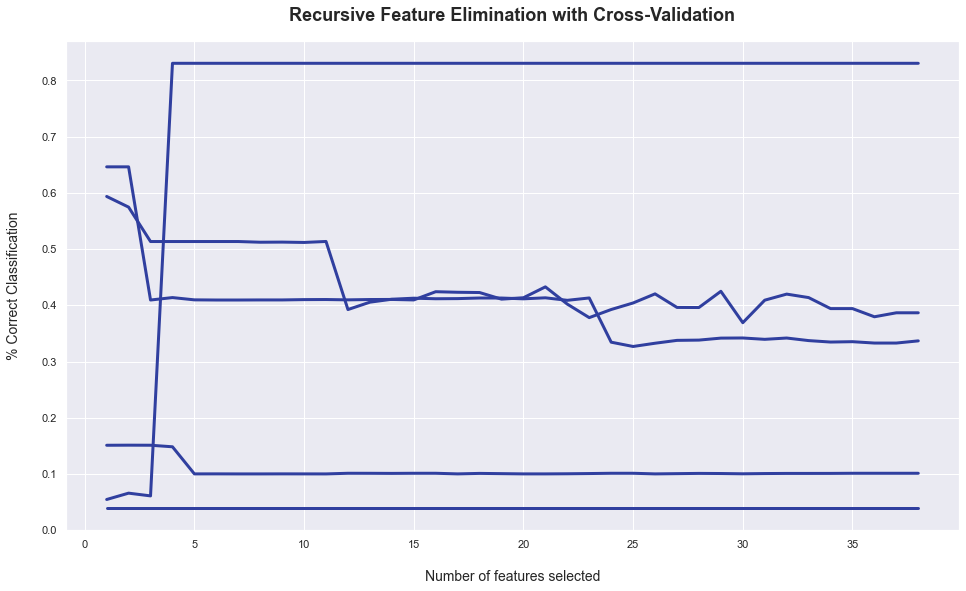

In [106]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

In [107]:
from numpy import array

mask = rfecv.get_support()
features = array(X_rfecv.columns) 
best_features = features[mask]
 
print("All features: ", X_rfecv.shape[1])
print(features)

print("Selected best: ", best_features.shape[0])
print(features[mask])

All features:  38
['job' 'education' 'housing' 'loan' 'month' 'pdays' 'previous'
 'emp.var.rate' 'cons.price.idx' 'cons.conf.idx' 'euribor3m' 'nr.employed'
 'age_1' 'age_2' 'age_3' 'age_4' 'age_5' 'age_6' 'age_7'
 'marital_divorced' 'marital_married' 'marital_single' 'contact_cellular'
 'contact_telephone' 'day_of_week_fri' 'day_of_week_mon' 'day_of_week_thu'
 'day_of_week_tue' 'day_of_week_wed' 'campaign_1' 'campaign_2'
 'campaign_3' 'campaign_4' 'campaign_5' 'campaign_6' 'poutcome_failure'
 'poutcome_nonexistent' 'poutcome_success']
Selected best:  4
['job' 'education' 'month' 'euribor3m']


In [108]:
bank = df[best_features]

In [109]:
bank

,job,education,month,euribor3m
0,0.029307,0.25,1.000000,0.957379
1,0.327334,0.50,1.000000,0.957379
2,0.327334,0.50,1.000000,0.957379
3,1.000000,0.25,1.000000,0.957379
4,0.327334,0.50,1.000000,0.957379
...,...,...,...,...
41183,0.095881,1.00,0.305375,0.089322
41184,0.855429,1.00,0.305375,0.089322
41185,0.095881,0.75,0.305375,0.089322
41186,0.614053,1.00,0.305375,0.089322


## Modeling

In [110]:
x = df.drop(columns=['y'])
#x = bank
y = df['y']

In [111]:
x_train,x_test,y_train,y_test=train_test_split(x,y,stratify=y,test_size=0.2,random_state=123)

In [112]:
logreg = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()
lgbm = lgb.LGBMClassifier()
gbc = GradientBoostingClassifier()
gnb = GaussianNB()
bc = BaggingClassifier()
ab = AdaBoostClassifier()

In [113]:
models = [logreg,knn,dt,rf,xgb,lgbm,gbc,gnb,bc,ab]
score=[]
rata=[]
std=[]

for i in models:
    skfold=StratifiedKFold(n_splits=5)
    estimator=Pipeline([
        ('model',i)])
    model_cv=cross_val_score(estimator,x_train,y_train,cv=skfold,scoring='f1_weighted')
    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM','Gradient Boosting Classifier','Naive Bayes','Bagging Classifier','Adaboost Classifier'],'mean f1 weighted':rata,'sdev':std}).set_index('model').sort_values(by='mean f1 weighted',ascending=False)

,mean f1 weighted,sdev
model,,
LightGBM,0.878319,0.002185
Gradient Boosting Classifier,0.877644,0.001290
XGBoost,0.877446,0.001466
Logistic Regression,0.872875,0.002198
Adaboost Classifier,0.872272,0.001863
Random Forest,0.870286,0.001279
KNN,0.865679,0.001198
Bagging Classifier,0.865023,0.002078
Naive Bayes,0.849341,0.004250


In [114]:
models = [logreg,knn,dt,rf,xgb,lgbm,gbc,gnb,bc,ab]
score_roc_auc = []

def y_pred_func(i):
    estimator=Pipeline([
        ('model',i)])
    x_train,x_test
    
    estimator.fit(x_train,y_train)
    return(estimator,estimator.predict(x_test),x_test)

for i,j in zip(models, ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM','Gradient Boosting Classifier','Naive Bayes','Bagging Classifier','Adaboost Classifier']):
    estimator,y_pred,X_test = y_pred_func(i)
    y_predict_proba = estimator.predict_proba(x_test)[:,1]
    score_roc_auc.append(roc_auc_score(y_test,y_predict_proba))
    print(j,'\n', classification_report(y_test,y_pred))
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM','Gradient Boosting Classifier','Naive Bayes','Bagging Classifier','Adaboost Classifier'],
             'roc_auc score':score_roc_auc}).set_index('model').sort_values(by='roc_auc score',ascending=False)

Logistic Regression 
               precision    recall  f1-score   support

           0       0.91      0.98      0.95      6372
           1       0.67      0.25      0.36       831

    accuracy                           0.90      7203
   macro avg       0.79      0.62      0.65      7203
weighted avg       0.88      0.90      0.88      7203

KNN 
               precision    recall  f1-score   support

           0       0.91      0.98      0.94      6372
           1       0.56      0.24      0.34       831

    accuracy                           0.89      7203
   macro avg       0.74      0.61      0.64      7203
weighted avg       0.87      0.89      0.87      7203

Decision Tree 
               precision    recall  f1-score   support

           0       0.91      0.91      0.91      6372
           1       0.34      0.34      0.34       831

    accuracy                           0.85      7203
   macro avg       0.63      0.63      0.63      7203
weighted avg       0.85      0

,roc_auc score
model,
Gradient Boosting Classifier,0.807279
LightGBM,0.805902
Adaboost Classifier,0.801461
Logistic Regression,0.795531
XGBoost,0.793160
Random Forest,0.775082
Naive Bayes,0.766526
Bagging Classifier,0.740813
KNN,0.699568


In [115]:
def calc_train_error(X_train, y_train, model):
#     '''returns in-sample error for already fit model.'''
    predictions = model.predict(X_train)
    predictProba = model.predict_proba(X_train)
    accuracy = accuracy_score(y_train, predictions)
    f1 = f1_score(y_train, predictions, average='weighted')
    roc_auc = roc_auc_score(y_train, predictProba[:,1])
    recall = recall_score(y_train, predictions)
    precision = precision_score(y_train, predictions)
    report = classification_report(y_train, predictions)
    return { 
        'report': report, 
        'f1' : f1, 
        'roc': roc_auc, 
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }
    
def calc_validation_error(X_test, y_test, model):
#     '''returns out-of-sample error for already fit model.'''
    predictions = model.predict(X_test)
    predictProba = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average='weighted')
    roc_auc = roc_auc_score(y_test, predictProba[:,1])
    recall = recall_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    report = classification_report(y_test, predictions)
    return { 
        'report': report, 
        'f1' : f1, 
        'roc': roc_auc, 
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }
    
def calc_metrics(X_train, y_train, X_test, y_test, model):
#     '''fits model and returns the in-sample error and out-of-sample error'''
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

In [116]:
from sklearn.model_selection import StratifiedKFold

K = 10
kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=123)

In [117]:
data = x_train
target = y_train

In [118]:
train_errors_without_oversampling = []
validation_errors_without_oversampling = []

train_errors_with_random_oversampling = []
validation_errors_with_random_oversampling = []

train_errors_with_smote_oversampling = []
validation_errors_with_smote_oversampling = []

train_errors_with_random_undersampling = []
validation_errors_with_random_undersampling = []

for train_index, val_index in kf.split(data, target):
    
    # split data
    X_train, X_val = data.iloc[train_index], data.iloc[val_index]
    Y_train, Y_val = target.iloc[train_index], target.iloc[val_index]
    
#     print(len(X_val), (len(X_train) + len(X_val)))
    ros = RandomOverSampler(random_state = 123, sampling_strategy=0.5)

    X_ros, Y_ros = ros.fit_resample(X_train, Y_train)
    
    smot = SMOTE(random_state = 123, sampling_strategy=0.5)

    X_smote, Y_smote = smot.fit_resample(X_train, Y_train)
    
    rus = RandomUnderSampler(random_state = 123, sampling_strategy=0.5)

    X_rus, Y_rus = rus.fit_resample(X_train, Y_train)

    # instantiate model
    lgbm = lgb.LGBMClassifier()
    estimator=Pipeline([
        ('model',lgbm)
    ])

    #calculate errors
    train_error_without_oversampling, val_error_without_oversampling = calc_metrics(X_train, Y_train, X_val, Y_val, estimator)
    train_error_with_random_oversampling, val_error_with_random_oversampling = calc_metrics(X_ros, Y_ros, X_val, Y_val, estimator)
    train_error_with_smote_oversampling, val_error_with_smote_oversampling = calc_metrics( X_smote, Y_smote, X_val, Y_val, estimator)
    train_error_with_random_undersampling, val_error_with_random_undersampling = calc_metrics(X_rus, Y_rus, X_val, Y_val, estimator)
    
    # append to appropriate list
    train_errors_without_oversampling.append(train_error_without_oversampling)
    validation_errors_without_oversampling.append(val_error_without_oversampling)
    
    train_errors_with_random_oversampling.append(train_error_with_random_oversampling)
    validation_errors_with_random_oversampling.append(val_error_with_random_oversampling)
    
    train_errors_with_smote_oversampling.append(train_error_with_smote_oversampling)
    validation_errors_with_smote_oversampling.append(val_error_with_smote_oversampling)
    
    train_errors_with_random_undersampling.append(train_error_with_random_undersampling)
    validation_errors_with_random_undersampling.append(val_error_with_random_undersampling)

In [119]:
listItem = []

for tr,val in zip(train_errors_without_oversampling,validation_errors_without_oversampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))
    
dfEvaluate = pd.DataFrame(listItem, 
                    columns=['Train Accuracy', 
                            'Test Accuracy', 
                            'Train ROC AUC', 
                            'Test ROC AUC', 
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.913726,0.900069,0.875172,0.836912,0.897585,0.879929,0.335115,0.261261,0.802400,0.674419
1,0.914115,0.897952,0.879653,0.803093,0.898899,0.878472,0.347695,0.262048,0.791635,0.639706
2,0.914308,0.895869,0.877767,0.790595,0.898589,0.876287,0.341683,0.256024,0.802983,0.615942
3,0.913575,0.901423,0.877214,0.818000,0.897682,0.883437,0.338009,0.286145,0.796223,0.669014
4,0.912842,0.899688,0.879382,0.805689,0.896693,0.883141,0.333333,0.298193,0.790808,0.638710
5,0.912534,0.901076,0.882835,0.785304,0.896804,0.882974,0.337788,0.285285,0.779491,0.669014
6,0.914038,0.896564,0.880049,0.790597,0.898328,0.878623,0.341129,0.276276,0.798905,0.617450
7,0.913768,0.897258,0.878315,0.775031,0.898233,0.880254,0.342800,0.288288,0.792278,0.619355
8,0.912495,0.901076,0.879266,0.800954,0.896205,0.882141,0.330772,0.276276,0.788217,0.676471
9,0.913266,0.901076,0.880473,0.804045,0.897255,0.881285,0.335783,0.267267,0.793839,0.684615


In [120]:
listItem = []

for tr,val in zip(train_errors_with_random_oversampling,validation_errors_with_smote_oversampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))
    
dfEvaluate = pd.DataFrame(listItem, 
                    columns=['Train Accuracy', 
                            'Test Accuracy', 
                            'Train ROC AUC', 
                            'Test ROC AUC', 
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.821329,0.897294,0.889576,0.826745,0.814313,0.880827,0.613446,0.294294,0.804092,0.616352
1,0.818655,0.899341,0.886767,0.796448,0.811239,0.883388,0.605598,0.304217,0.801870,0.631250
2,0.818858,0.892051,0.887424,0.784805,0.811339,0.876950,0.604465,0.295181,0.803431,0.560000
3,0.819294,0.897605,0.884112,0.811873,0.811742,0.883034,0.604465,0.316265,0.804830,0.606936
4,0.815458,0.900035,0.887816,0.807099,0.807835,0.888459,0.599843,0.361446,0.796273,0.612245
5,0.819096,0.899688,0.888086,0.791180,0.811816,0.883217,0.607778,0.300300,0.801518,0.641026
6,0.818486,0.895869,0.889415,0.790985,0.811110,0.881981,0.605947,0.321321,0.801037,0.591160
7,0.819765,0.895869,0.890835,0.769235,0.812521,0.882223,0.608912,0.324324,0.802736,0.590164
8,0.820840,0.898646,0.886057,0.795323,0.813656,0.882913,0.610743,0.306306,0.804688,0.625767
9,0.818544,0.896217,0.890789,0.794640,0.811238,0.880754,0.606906,0.303303,0.800460,0.601190


In [121]:
listItem = []

for tr,val in zip(train_errors_with_smote_oversampling,validation_errors_with_random_oversampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))
    
dfEvaluate = pd.DataFrame(listItem, 
                    columns=['Train Accuracy', 
                            'Test Accuracy', 
                            'Train ROC AUC', 
                            'Test ROC AUC', 
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.926259,0.880985,0.962614,0.837909,0.924680,0.883954,0.817405,0.546547,0.954874,0.486631
1,0.928177,0.874349,0.962530,0.794972,0.926669,0.878402,0.821503,0.536145,0.956932,0.461140
2,0.927799,0.874349,0.962914,0.790961,0.926296,0.879074,0.821416,0.551205,0.955763,0.462121
3,0.927334,0.872614,0.962023,0.818261,0.925847,0.878127,0.821765,0.560241,0.953846,0.457002
4,0.928497,0.870531,0.962213,0.801081,0.926995,0.877032,0.821939,0.572289,0.957538,0.451306
5,0.928295,0.874349,0.962413,0.792555,0.926814,0.877975,0.822637,0.528529,0.956116,0.461942
6,0.928353,0.877473,0.962317,0.794766,0.926899,0.879823,0.823770,0.516517,0.955111,0.472527
7,0.927627,0.864977,0.962750,0.766068,0.926083,0.870389,0.819672,0.519520,0.957035,0.430348
8,0.928818,0.881291,0.962615,0.794977,0.927307,0.884184,0.821765,0.546547,0.958795,0.487936
9,0.929342,0.875738,0.962633,0.803421,0.927956,0.879597,0.827258,0.540541,0.954715,0.467532


In [122]:
listItem = []

for tr,val in zip(train_errors_with_random_undersampling,validation_errors_with_random_undersampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))
    
dfEvaluate = pd.DataFrame(listItem, 
                    columns=['Train Accuracy', 
                            'Test Accuracy', 
                            'Train ROC AUC', 
                            'Test ROC AUC', 
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.822141,0.868494,0.886690,0.831956,0.814606,0.875077,0.607417,0.564565,0.811607,0.445498
1,0.823759,0.866366,0.886742,0.793281,0.816168,0.872684,0.608216,0.545181,0.816226,0.436145
2,0.825874,0.868101,0.890971,0.785975,0.818030,0.874788,0.606880,0.563253,0.824410,0.443128
3,0.819528,0.870531,0.886730,0.814078,0.810925,0.877404,0.591516,0.581325,0.816505,0.451991
4,0.824538,0.864283,0.888862,0.798541,0.816160,0.872614,0.598864,0.581325,0.827030,0.433708
5,0.825593,0.867060,0.888029,0.787477,0.818543,0.873842,0.617107,0.561562,0.814733,0.441038
6,0.828266,0.868101,0.886260,0.787605,0.820552,0.873182,0.610758,0.528529,0.829025,0.441103
7,0.825704,0.861854,0.887315,0.776583,0.817888,0.868701,0.607083,0.534535,0.823663,0.422803
8,0.825259,0.875043,0.889735,0.793808,0.817983,0.880115,0.613765,0.564565,0.816444,0.466501
9,0.823922,0.870184,0.885490,0.799155,0.816413,0.877237,0.609422,0.585586,0.815742,0.452436


In [123]:
for rep in validation_errors_with_random_oversampling :
    print(rep['report'])

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      2549
           1       0.49      0.55      0.51       333

    accuracy                           0.88      2882
   macro avg       0.71      0.74      0.72      2882
weighted avg       0.89      0.88      0.88      2882

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      2549
           1       0.46      0.54      0.50       332

    accuracy                           0.87      2881
   macro avg       0.70      0.73      0.71      2881
weighted avg       0.88      0.87      0.88      2881

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      2549
           1       0.46      0.55      0.50       332

    accuracy                           0.87      2881
   macro avg       0.70      0.73      0.72      2881
weighted avg       0.88      0.87      0.88      2881

              preci

### Hyperparameter Tuning

In [145]:
hyperparam_space=[{
    'model__max_bin': [255, 275, 300, 230],
    'model__num_leaves':[31, 21, 41, 51],
    'model__min_data_in_leaf': [20, 15, 30, 40],
    'model__num_iterations':[100,75, 125, 150],
    'model__learning_rate': [0.1, 0.075, 0.125, 0.05],
    'model__random_state': [123]
}]

In [146]:
grid = GridSearchCV(estimator, n_jobs=-1, param_grid=hyperparam_space, scoring='f1_weighted', cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=123))

In [147]:
grid.fit(x_train,y_train)
print(grid.best_score_)
print(grid.best_params_)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
0.8805676817016893
{'model__learning_rate': 0.075, 'model__max_bin': 275, 'model__min_data_in_leaf': 20, 'model__num_iterations': 150, 'model__num_leaves': 51, 'model__random_state': 123}


In [148]:
estimator=Pipeline([
    ('oversampling',ros),
    ('model',lgbm)
])
estimator.fit(x_train, y_train)

Pipeline(steps=[('oversampling',
                 RandomOverSampler(random_state=123, sampling_strategy=0.5)),
                ('model', LGBMClassifier())])

In [149]:
best_model =grid.best_estimator_
print(best_model)

Pipeline(steps=[('oversampling',
                 RandomOverSampler(random_state=123, sampling_strategy=0.5)),
                ('model',
                 LGBMClassifier(learning_rate=0.075, max_bin=275,
                                min_data_in_leaf=20, num_iterations=150,
                                num_leaves=51, random_state=123))])


In [150]:
y_pred_default = estimator.predict(x_test)
y_pred_proba_default = estimator.predict_proba(x_test)
y_pred_tuned = best_model.predict(x_test)
y_pred_proba_tuned = best_model.predict_proba(x_test)

roc_auc_default = roc_auc_score(y_test, y_pred_proba_default[:,1])
roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned[:,1])

print('ROC AUC Score Default LGBM : ', roc_auc_default)
print('ROC AUC Score Tuned LGBM : ', roc_auc_tuned)

ROC AUC Score Default LGBM :  0.8041053556360823
ROC AUC Score Tuned LGBM :  0.8003025231476761


In [151]:
report_default = classification_report(y_test, y_pred_default)
report_tuned = classification_report(y_test, y_pred_tuned)

print('Classification Report Default LGBM : \n', report_default)
print('Classification Report Tuned LGBM : \n', report_tuned)

Classification Report Default LGBM : 
               precision    recall  f1-score   support

           0       0.94      0.91      0.93      6372
           1       0.46      0.56      0.50       831

    accuracy                           0.87      7203
   macro avg       0.70      0.74      0.72      7203
weighted avg       0.89      0.87      0.88      7203

Classification Report Tuned LGBM : 
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      6372
           1       0.46      0.55      0.50       831

    accuracy                           0.87      7203
   macro avg       0.70      0.73      0.72      7203
weighted avg       0.88      0.87      0.88      7203



### Threshold Tuning

In [152]:
best_model.fit(x_train,y_train)
y_pred = best_model.predict_proba(x_test)
y_pred = y_pred[:,1]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


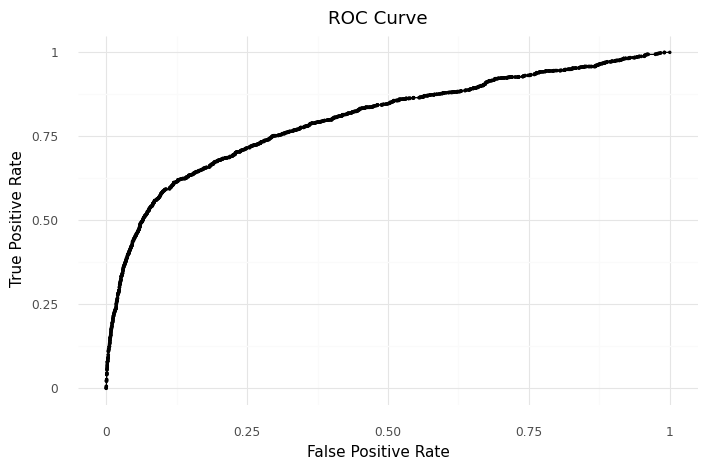

<ggplot: (177965224774)>

In [153]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Plot the ROC curve
df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})
df_fpr_tpr.head()

# Create the data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate')+
    ylab('True Positive Rate')+
    theme_minimal()
)

Best Threshold: 0.2665 with G-Mean: 0.7379
FPR: 0.1921, TPR: 0.6739


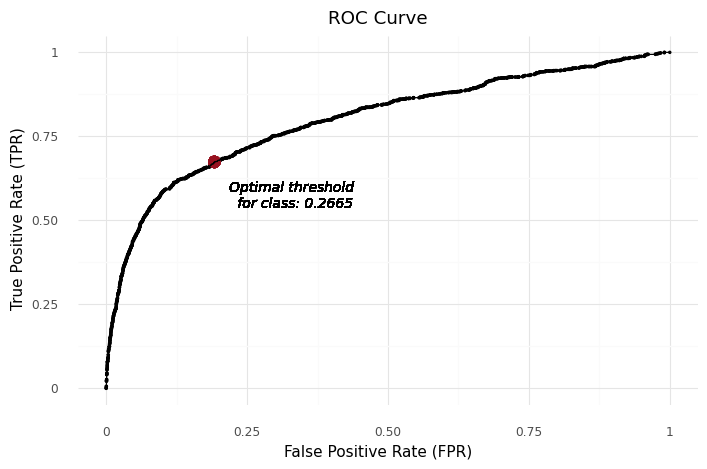

<ggplot: (177970884503)>

In [154]:
gmean = np.sqrt(tpr * (1 - fpr))

# Find the optimal threshold
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

# Create data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = fprOpt,
                   y = tprOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    geom_text(aes(x = fprOpt,
                  y = tprOpt),
              label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_minimal()
)

Best Threshold: 0.3513 with Youden J statistic: 0.7361
FPR: 0.1273, TPR: 0.6209


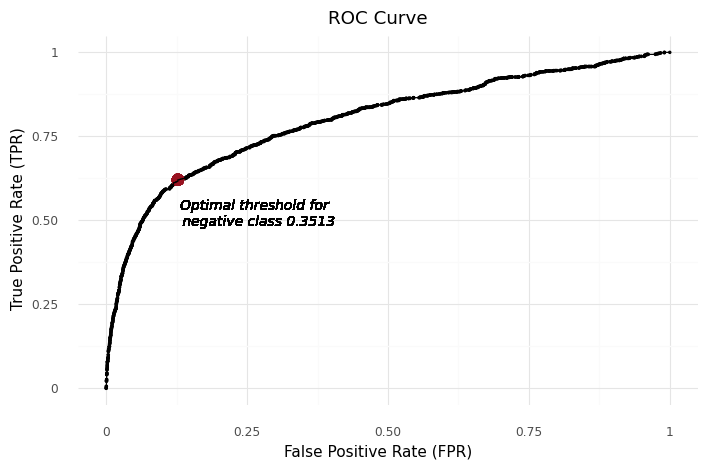

<ggplot: (177979952809)>

In [155]:
youdenJ = tpr - fpr

# Find the optimal threshold
index = np.argmax(youdenJ)
thresholdOpt = round(thresholds[index], ndigits = 4)
youdenJOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with Youden J statistic: {}'.format(thresholdOpt, youdenJOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

# Create a data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = fprOpt,
                   y = tprOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    # Annotate the text
    geom_text(aes(x = fprOpt,
                  y = tprOpt),
              label = 'Optimal threshold for \n negative class {}'.format(thresholdOpt),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_minimal()
)

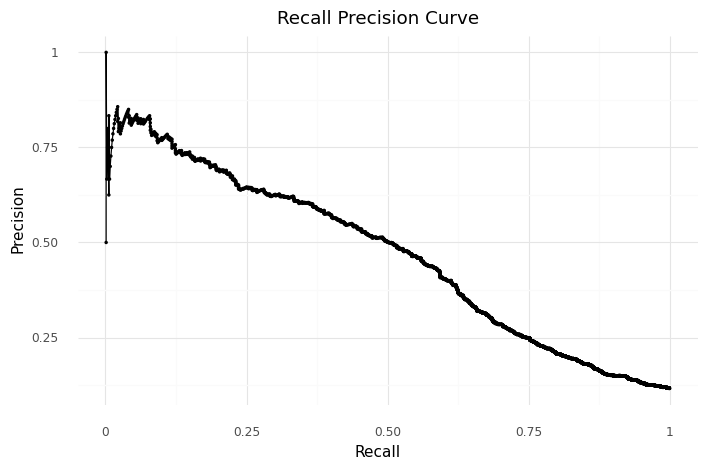

<ggplot: (177982554284)>

In [156]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# Plot the ROC curve
df_recall_precision = pd.DataFrame({'Precision':precision[:-1],
                                    'Recall':recall[:-1],
                                    'Threshold':thresholds})
df_recall_precision.head()

# Creat a data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_recall_precision)+
    geom_point(aes(x = 'Recall',
                   y = 'Precision'),
               size = 0.4)+
    geom_line(aes(x = 'Recall',
                  y = 'Precision'))+
    labs(title = 'Recall Precision Curve')+
    xlab('Recall')+
    ylab('Precision')+
    theme_minimal()
)

Best Threshold: 0.5492 with F-Score: 0.5046
Recall: 0.5271, Precision: 0.484


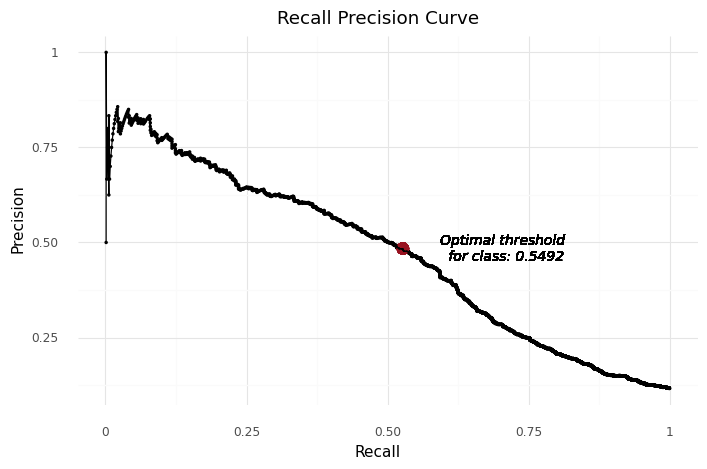

<ggplot: (177982468392)>

In [157]:
fscore = (2 * precision * recall) / (precision + recall)

# Find the optimal threshold
index = np.argmax(fscore)
thresholdOpt = round(thresholds[index], ndigits = 4)
fscoreOpt = round(fscore[index], ndigits = 4)
recallOpt = round(recall[index], ndigits = 4)
precisionOpt = round(precision[index], ndigits = 4)
print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))
print('Recall: {}, Precision: {}'.format(recallOpt, precisionOpt))

# Create a data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_recall_precision)+
    geom_point(aes(x = 'Recall',
                   y = 'Precision'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = recallOpt,
                   y = precisionOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'Recall',
                  y = 'Precision'))+
    # Annotate the text
    geom_text(aes(x = recallOpt,
                  y = precisionOpt),
              label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
              nudge_x = 0.18,
              nudge_y = 0,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'Recall Precision Curve')+
    xlab('Recall')+
    ylab('Precision')+
    theme_minimal()
)

Length of sequence: 10000
Best Threshold: 0.5488 with F-Score: 0.5046


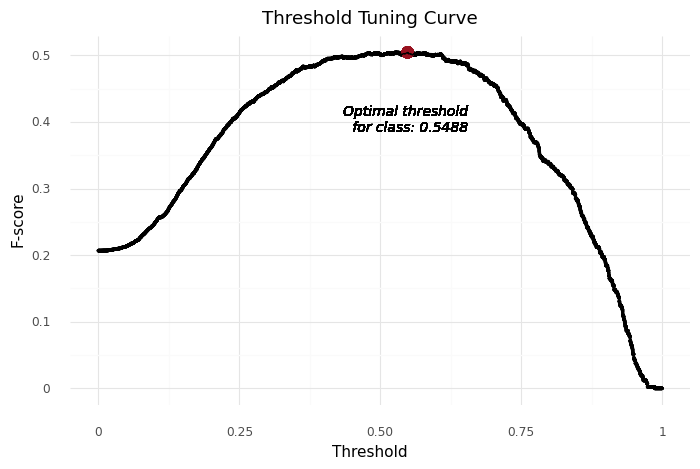

<ggplot: (177982495732)>

In [158]:
thresholds = np.arange(0.0, 1.0, 0.0001)
fscore = np.zeros(shape=(len(thresholds)))
print('Length of sequence: {}'.format(len(thresholds)))

# Fit the model
for index, elem in enumerate(thresholds):
    # Corrected probabilities
    y_pred_prob = (y_pred > elem).astype('int')
    # Calculate the f-score
    fscore[index] = f1_score(y_test, y_pred_prob)

# Find the optimal threshold
index = np.argmax(fscore)
thresholdOpt = round(thresholds[index], ndigits = 4)
fscoreOpt = round(fscore[index], ndigits = 4)
print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))

# Plot the threshold tuning
df_threshold_tuning = pd.DataFrame({'F-score':fscore,
                                    'Threshold':thresholds})
df_threshold_tuning.head()

plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_threshold_tuning)+
    geom_point(aes(x = 'Threshold',
                   y = 'F-score'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = thresholdOpt,
                   y = fscoreOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'Threshold',
                   y = 'F-score'))+
    # Annotate the text
    geom_text(aes(x = thresholdOpt,
                  y = fscoreOpt),
              label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
              nudge_x = 0,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'Threshold Tuning Curve')+
    xlab('Threshold')+
    ylab('F-score')+
    theme_minimal()
)

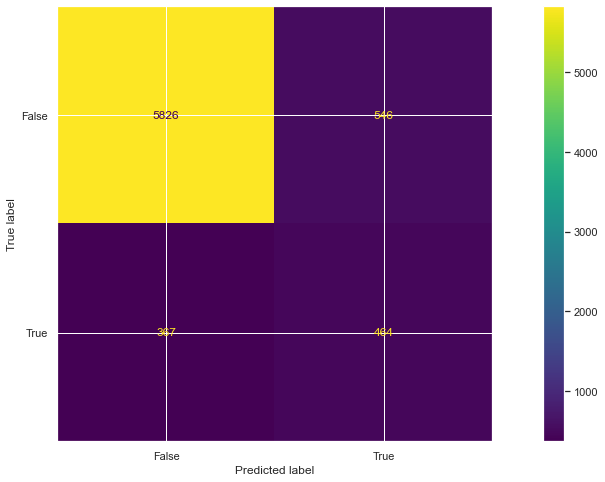

In [159]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_default)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [160]:
print(classification_report(y_test,y_pred_tuned))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      6372
           1       0.46      0.55      0.50       831

    accuracy                           0.87      7203
   macro avg       0.70      0.73      0.72      7203
weighted avg       0.88      0.87      0.88      7203



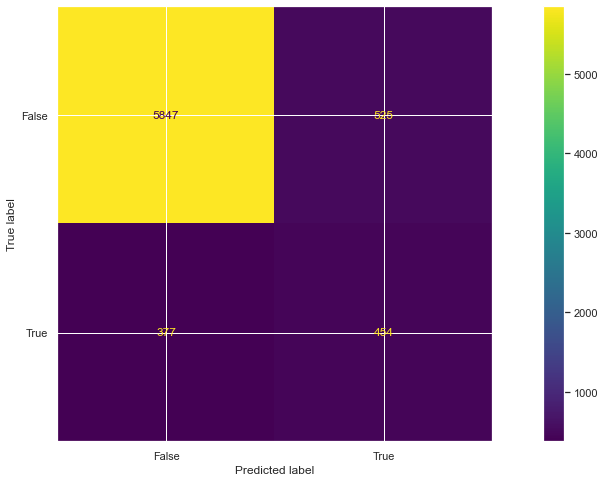

In [161]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_tuned)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [162]:
decisions = (best_model.predict_proba(x_test)[:,1] >= thresholdOpt).astype(int)

In [163]:
print(roc_auc_score(y_test,decisions))

0.7268932105941834


In [164]:
print(classification_report(y_test,decisions))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93      6372
           1       0.48      0.53      0.50       831

    accuracy                           0.88      7203
   macro avg       0.71      0.73      0.72      7203
weighted avg       0.89      0.88      0.88      7203



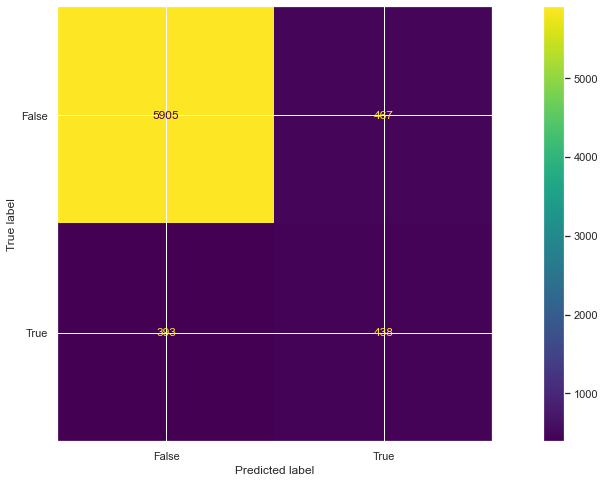

In [165]:
confusion_matrix = metrics.confusion_matrix(y_test, decisions)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [166]:
matthews_corrcoef(y_test, y_pred_default)


0.43490134685429227

In [167]:
matthews_corrcoef(y_test, y_pred_tuned)


0.4324861582376571

In [168]:
matthews_corrcoef(y_test, decisions)


0.4373853917222071

### Feature Importances

Mari sekarang kita lihat fitur/kolom apa saja yang paling penting untuk model LGBM kita

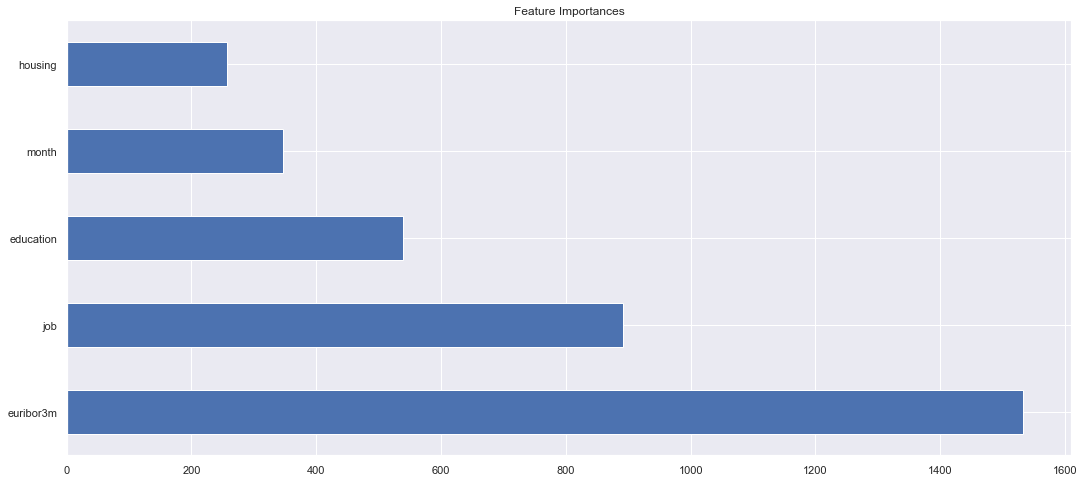

In [170]:
coef1 = pd.Series(best_model['model'].feature_importances_,index = data.columns).sort_values(ascending = False).head(5)
coef1.plot(kind='barh', title='Feature Importances')
plt.show()